In [1]:
# GARCH Analysis: predictions will be made using the already optimidez SARIMA models plus the GARCH models trained in this notebook

#Import the required modules for vectors and matrix operations, data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for time series model estimation:
import statsmodels.tsa as smt
#Import Pandas
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import arch as arch
import pmdarima
import statsmodels
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch

In [2]:
# read dataset
dataSales = pd.read_csv('salesdaily.csv', sep=',')
dataSales.head(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [3]:
# pass string to datetime
dataSales['datum'] = [datetime.datetime.strptime(x, "%m/%d/%Y") for x in dataSales['datum']]
type(dataSales.loc[0,'datum'])

pandas._libs.tslibs.timestamps.Timestamp

In [4]:
# set date to index
dataSales.rename(columns={'datum':'date'}, inplace=True)
dataSales.set_index('date', inplace=True)
dataSales.head(5)

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
date,,,,,,,,,,,,
2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [5]:
dataSales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   M01AB         2106 non-null   float64
 1   M01AE         2106 non-null   float64
 2   N02BA         2106 non-null   float64
 3   N02BE         2106 non-null   float64
 4   N05B          2106 non-null   float64
 5   N05C          2106 non-null   float64
 6   R03           2106 non-null   float64
 7   R06           2106 non-null   float64
 8   Year          2106 non-null   int64  
 9   Month         2106 non-null   int64  
 10  Hour          2106 non-null   int64  
 11  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(1)
memory usage: 213.9+ KB


In [6]:
# split time series
m01ab = dataSales[['M01AB']]
m01ae = dataSales[['M01AE']]
n02ba = dataSales[['N02BA']]
n02be = dataSales[['N02BE']]
n05b = dataSales[['N05B']]
n05c = dataSales[['N05C']]
r03 = dataSales[['R03']]
r06 = dataSales[['R06']]

# Forecasting SARIMA + GARCH

### M01AB

In [7]:
m01ab.head(5)

,M01AB
date,
2014-01-02,0.0
2014-01-03,8.0
2014-01-04,2.0
2014-01-05,4.0
2014-01-06,5.0


In [8]:
# transformed timeseries
np.log(m01ab+1).head(5)

,M01AB
date,
2014-01-02,0.000000
2014-01-03,2.197225
2014-01-04,1.098612
2014-01-05,1.609438
2014-01-06,1.791759


In [9]:
# train - test split
log_m01ab = np.log(m01ab+1)

index = int(len(log_m01ab.index)*0.8)
log_m01ab_train = log_m01ab.iloc[:index,:]
log_m01ab_test = log_m01ab.iloc[index:,:]
print("Train: {} | Test: {}".format(log_m01ab_train.shape, log_m01ab_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [10]:
log_m01ab_test.head(5)

,M01AB
date,
2018-08-13,1.465568
2018-08-14,0.845868
2018-08-15,2.234306
2018-08-16,1.465568
2018-08-17,1.202972


In [11]:
# create SARIMA model
log_m01ab_fit = sm.tsa.statespace.SARIMAX(log_m01ab_train,order=(6,1,4),seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_m01ab_fit_sarima = log_m01ab_fit.fit()

In [12]:
# output of best sarimax model
print(log_m01ab_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_m01ab_fit_sarima.resid, lags=[6], return_df=True))

                                      SARIMAX Results                                       
Dep. Variable:                                M01AB   No. Observations:                 1684
Model:             SARIMAX(6, 1, 4)x(0, 0, [1], 12)   Log Likelihood               -1228.080
Date:                              Sat, 19 Jun 2021   AIC                           2480.160
Time:                                      19:40:33   BIC                           2545.178
Sample:                                  01-02-2014   HQIC                          2504.255
                                       - 08-12-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2054      2.136     -0.096      0.923      -4.391       3.981
ar.L2         -0.56

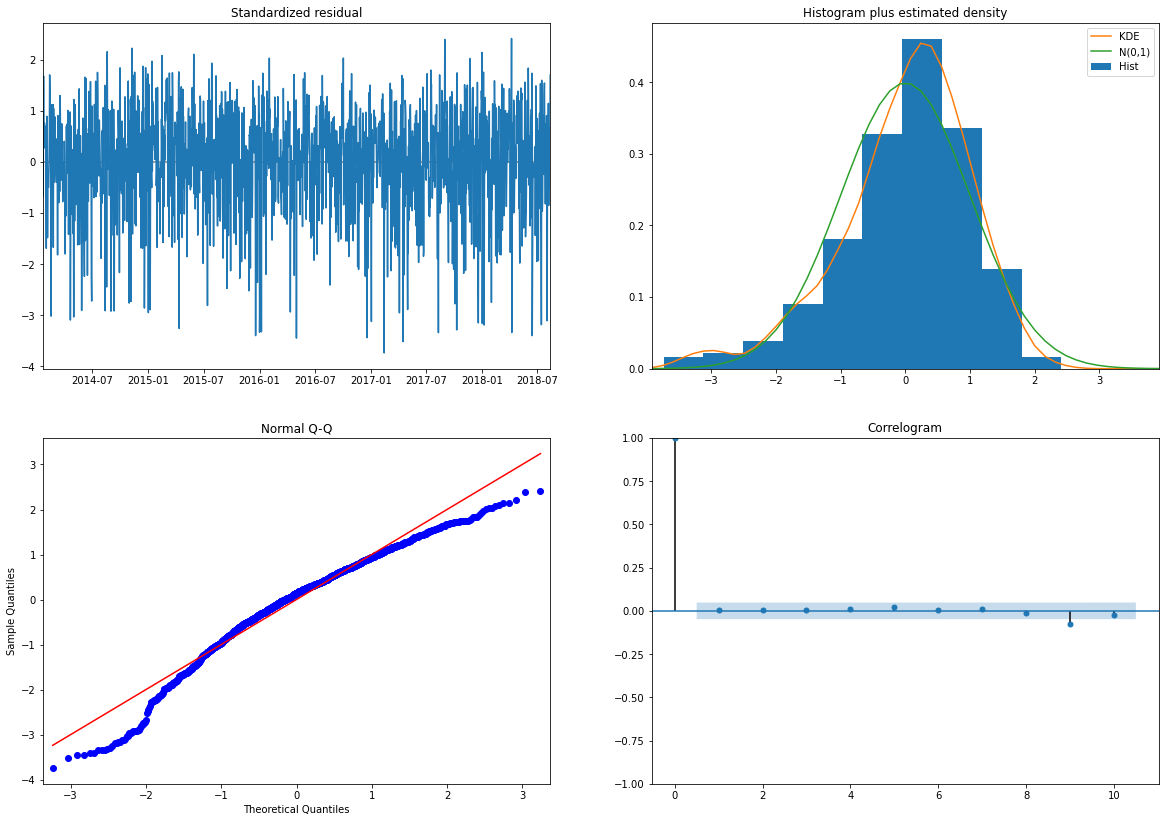

In [13]:
# visual check for residuals
log_m01ab_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [14]:
# create a variable for the residuals
sarima_residuals = log_m01ab_fit_sarima.resid
sarima_residuals.head(5)

date
2014-01-02    0.000000
2014-01-03    2.197225
2014-01-04   -0.772794
2014-01-05    1.519755
2014-01-06    0.480687
dtype: float64

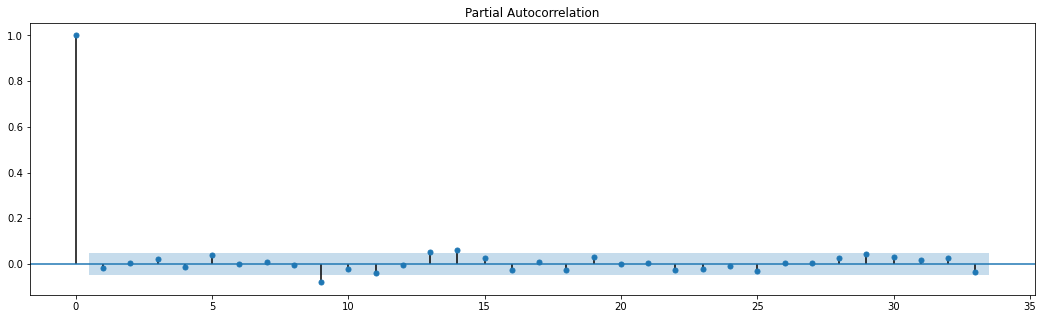

In [15]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals)
plt.show()

In [16]:
# altough a GARCH(9,1) would appear to provide better results, prediction error is lower with a GARCH(1,1)
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch_model = arch.arch_model(sarima_residuals, p=1, q=1)
garch_fitted = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 898029259572.4601
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2496207067.116084
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4961.033985147296
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1816.9810210133276
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1253.8411595879281
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1253.8410434619248
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1253.8410428472166
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1253.8410428472166
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 7


In [17]:
# Use SARIMA to predict mu
predicted_mu = log_m01ab_fit_sarima.get_forecast('2019-10-08')
predicted_mu = predicted_mu.predicted_mean
predicted_mu = pd.DataFrame(list(predicted_mu), index=log_m01ab_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=422)
predicted_et = garch_forecast.mean.iloc[-1,:]
predicted_et = pd.DataFrame(list(predicted_et), index=log_m01ab_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et
prediction = np.exp(prediction-1)

In [18]:
prediction

,Prediction
date,
2018-08-13,1.877077
2018-08-14,1.817393
2018-08-15,1.799415
2018-08-16,1.865024
2018-08-17,1.843855
...,...
2019-10-04,1.876225
2019-10-05,1.876225
2019-10-06,1.876225


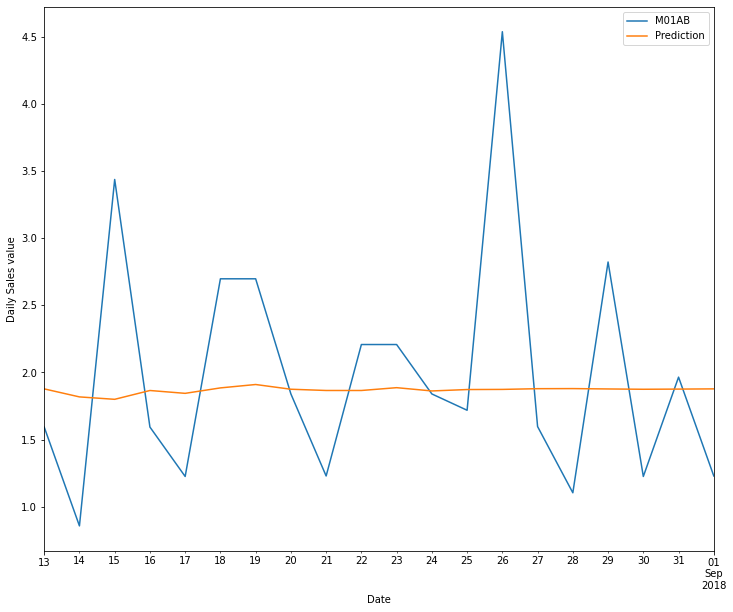

In [19]:
# plot all predictions in the same picture
ax = np.exp(log_m01ab_test-1)[:20].plot(figsize=(12, 10))
prediction[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [20]:
# Evaluate Model
results_garch = np.exp(log_m01ab_test-1).merge(prediction, on='date')
results_garch.head(15)

,M01AB,Prediction
date,,
2018-08-13,1.592918,1.877077
2018-08-14,0.857159,1.817393
2018-08-15,3.435994,1.799415
2018-08-16,1.592918,1.865024
2018-08-17,1.225039,1.843855
2018-08-18,2.696556,1.884378
2018-08-19,2.696556,1.909635
2018-08-20,1.839397,1.874464
2018-08-21,1.228717,1.865188


In [21]:
RMSE_garch = mean_squared_error(results_garch['M01AB'], results_garch['Prediction'], squared=False)
MAE_garch = mean_absolute_error(results_garch['M01AB'], results_garch['Prediction'])

results_garch_non_null = results_garch[results_garch['M01AB'] != 0]
MAPE_garch = np.abs(np.mean((results_garch_non_null['Prediction'] - results_garch_non_null['M01AB']) / results_garch_non_null['M01AB'])) # MAPE for non-null values

print('GARCH - M01AB')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch, MAE_garch, MAPE_garch))

GARCH - M01AB
RMSE: 1.1143986287307301 
MAE: 0.8490363332556122 
MAPE: 0.06358873339152647


In [22]:
# in-sample prediction
# SARIMAX
is_predicted_mu = log_m01ab_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu = is_predicted_mu.predicted_mean
is_predicted_mu = pd.DataFrame(list(is_predicted_mu), index=log_m01ab_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast = garch_fitted.forecast(horizon=len(log_m01ab_train.index), start='2014-01-02')
is_predicted_et = is_garch_forecast.mean.iloc[0,:]
is_predicted_et = pd.DataFrame(list(is_predicted_et), index=log_m01ab_train.index, columns=['Fit'])

# predict with SARIMA + GARCH
is_prediction = is_predicted_mu + is_predicted_et
is_prediction = np.exp(is_prediction-1)

In [23]:
is_prediction

,Fit
date,
2014-01-02,0.368411
2014-01-03,0.368411
2014-01-04,2.393726
2014-01-05,0.402978
2014-01-06,1.366860
...,...
2018-08-08,1.696066
2018-08-09,1.756708
2018-08-10,1.846418


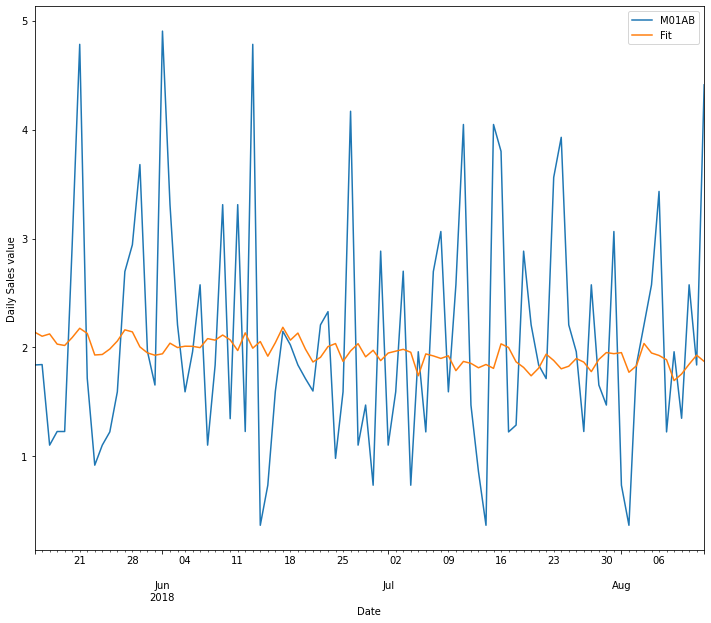

In [24]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_m01ab_train-1)[-90:].plot(figsize=(12, 10))
is_prediction[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [25]:
# analyse in-sample residuals
is_residuals = is_prediction['Fit'] - np.exp(log_m01ab_train-1)['M01AB']
arch_test = het_arch(is_residuals, maxlag=80)

# H0: constant variance
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

# H0: independent observations / residuals
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals, lags=[6], return_df=True))

# with these tests it can be confirmed that the fitted combined model is a good fit

Lagrange mulitplier p-value: 0.8097961405864443
F test p-value: 0.8176792212469082

Ljung-box test: 
    lb_stat  lb_pvalue
6  4.248031   0.643151


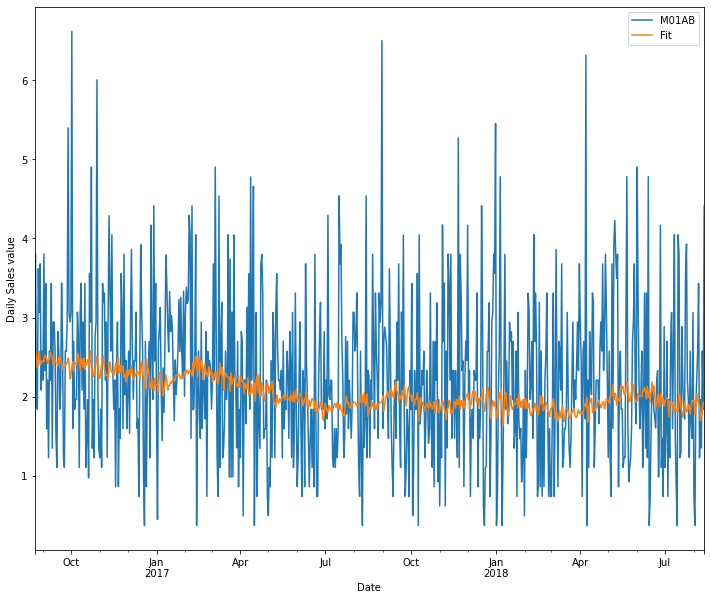

In [26]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_m01ab_train-1)[-720:].plot(figsize=(12, 10))
is_prediction[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

### M01AE

In [27]:
m01ae.head(5)

,M01AE
date,
2014-01-02,3.67
2014-01-03,4.00
2014-01-04,1.00
2014-01-05,3.00
2014-01-06,1.00


In [28]:
# transformed time series
np.log(m01ae+1).head(5)

,M01AE
date,
2014-01-02,1.541159
2014-01-03,1.609438
2014-01-04,0.693147
2014-01-05,1.386294
2014-01-06,0.693147


In [29]:
# train - test split
log_m01ae = np.log(m01ae+1)

index = int(len(log_m01ae.index)*0.8)
log_m01ae_train = log_m01ae.iloc[:index,:]
log_m01ae_test = log_m01ae.iloc[index:,:]
print("Train: {} | Test: {}".format(log_m01ae_train.shape, log_m01ae_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [30]:
# fit best SARIMA model
log_m01ae_fit = sm.tsa.statespace.SARIMAX(log_m01ae_train,order=(1,0,1),seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_m01ae_fit_sarima = log_m01ae_fit.fit()

In [31]:
# output of best sarimax model
print(log_m01ae_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_m01ae_fit_sarima.resid, lags=[1], return_df=True))

                                     SARIMAX Results                                      
Dep. Variable:                              M01AE   No. Observations:                 1684
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -1113.643
Date:                            Sat, 19 Jun 2021   AIC                           2235.287
Time:                                    19:41:32   BIC                           2256.969
Sample:                                01-02-2014   HQIC                          2243.321
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   7838.533      0.000       1.000       1.000
ma.L1         -0.9854      0.004   

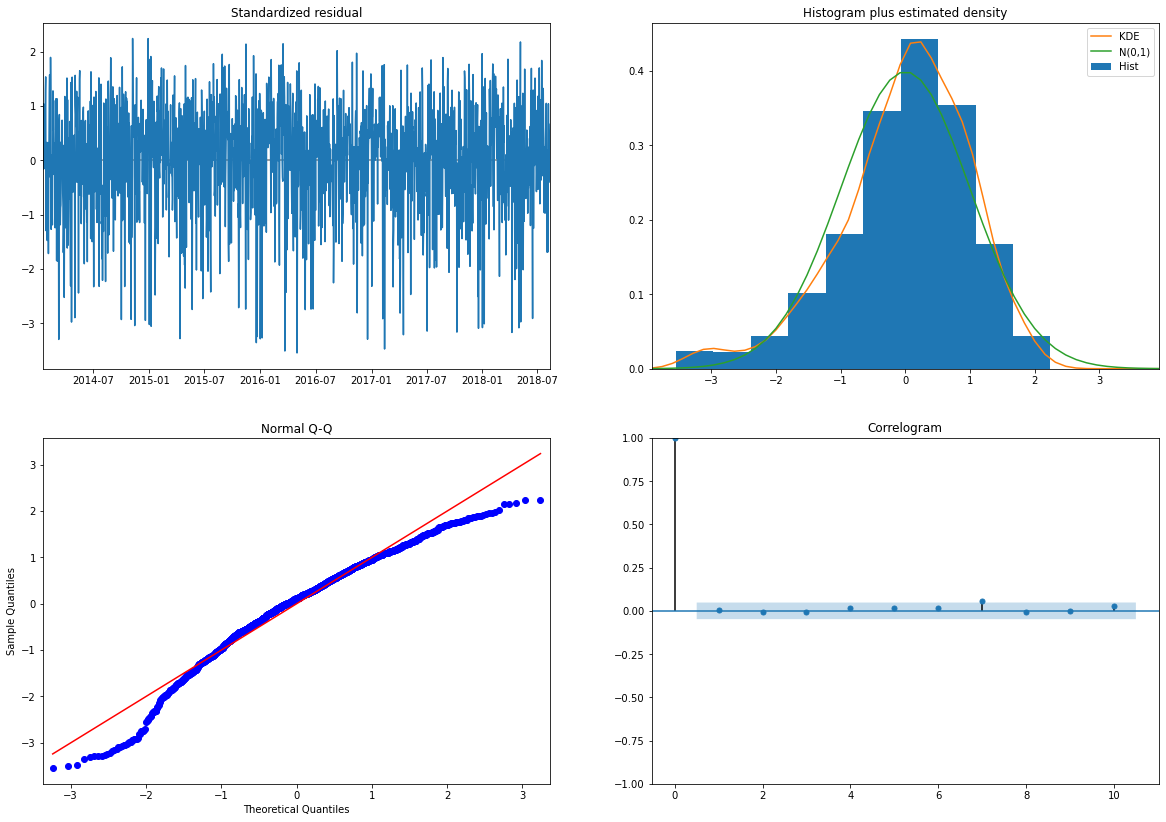

In [32]:
# visual check for residuals
log_m01ae_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [33]:
sarima_residuals2 = log_m01ae_fit_sarima.resid
sarima_residuals2.head(15)

date
2014-01-02    1.541159
2014-01-03    0.068272
2014-01-04   -0.916298
2014-01-05    0.693144
2014-01-06   -0.693153
2014-01-07   -0.693151
2014-01-08    1.386294
2014-01-09   -0.400484
2014-01-10    0.112791
2014-01-11    0.576608
2014-01-12   -1.168416
2014-01-13    1.651895
2014-01-14   -1.312856
2014-01-15    0.360098
2014-01-16   -0.107364
dtype: float64

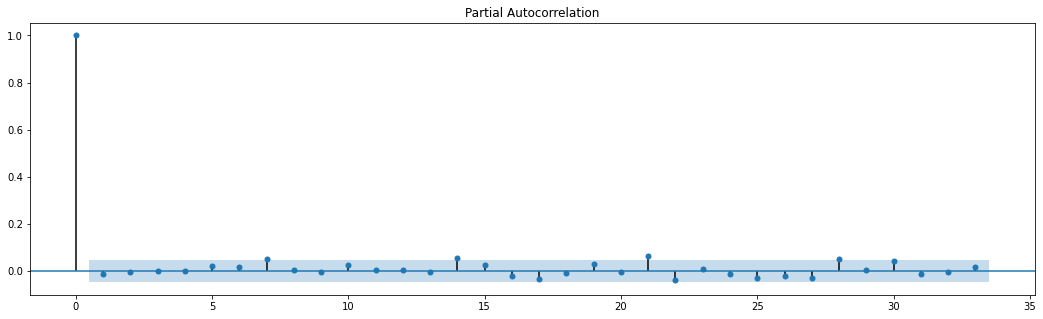

In [34]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals2)
plt.show()

In [35]:
# According to PACF analysis, a GARCH(7,1) better fits the remaining residues from the SARIMA model - although a (1,1) 
# could also be a good choise due to the low levels of partial auto-correlation
# fit a GARCH(7,1) model on the residuals of the ARIMA model
garch_model2 = arch.arch_model(sarima_residuals2, p=7, q=1)
garch_fitted2 = garch_model2.fit()

Iteration:      1,   Func. Count:     12,   Neg. LLF: 78420902531.7884
Iteration:      2,   Func. Count:     27,   Neg. LLF: 10343041182.134443
Iteration:      3,   Func. Count:     41,   Neg. LLF: 592942.5769072117
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1145.500062100216
Iteration:      5,   Func. Count:     68,   Neg. LLF: 1151.1971406692626
Iteration:      6,   Func. Count:     81,   Neg. LLF: 1136.83447758359
Iteration:      7,   Func. Count:     93,   Neg. LLF: 1135.2058124462656
Iteration:      8,   Func. Count:    104,   Neg. LLF: 1135.1500388831996
Iteration:      9,   Func. Count:    115,   Neg. LLF: 1135.0795334240552
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1136.8175166862452
Iteration:     11,   Func. Count:    138,   Neg. LLF: 1136.5012444939143
Iteration:     12,   Func. Count:    150,   Neg. LLF: 1135.8412735584716
Iteration:     13,   Func. Count:    162,   Neg. LLF: 1134.3315296038543
Iteration:     14,   Func. Count:    173,   Neg. LLF: 113

In [36]:
# Use SARIMA to predict mu
predicted_mu2 = log_m01ae_fit_sarima.get_forecast('2019-10-08')
predicted_mu2 = predicted_mu2.predicted_mean
predicted_mu2 = pd.DataFrame(list(predicted_mu2), index=log_m01ae_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast2 = garch_fitted2.forecast(horizon=422)
predicted_et2 = garch_forecast2.mean.iloc[-1,:]
predicted_et2 = pd.DataFrame(list(predicted_et2), index=log_m01ae_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction2 = predicted_mu2 + predicted_et2
prediction2 = np.exp(prediction2-1)

In [37]:
prediction2

,Prediction
date,
2018-08-13,1.630758
2018-08-14,1.654359
2018-08-15,1.627077
2018-08-16,1.615249
2018-08-17,1.654835
...,...
2019-10-04,1.623732
2019-10-05,1.623743
2019-10-06,1.623755


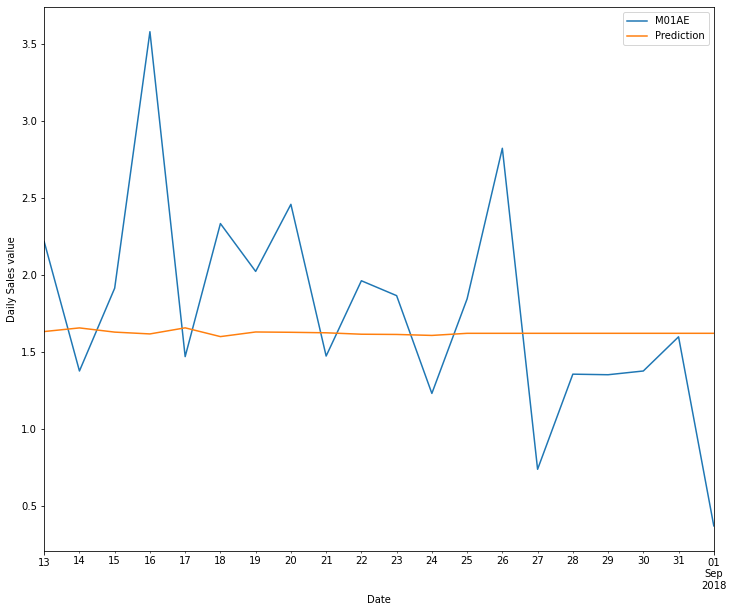

In [38]:
# plot predictions in the same picture
ax = np.exp(log_m01ae_test-1)[:20].plot(figsize=(12, 10))
prediction2[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [39]:
# Evaluate Model
results_garch2 = np.exp(log_m01ae_test-1).merge(prediction2, on='date')
results_garch2.head(15)

,M01AE,Prediction
date,,
2018-08-13,2.214634,1.630758
2018-08-14,1.374398,1.654359
2018-08-15,1.912605,1.627077
2018-08-16,3.579099,1.615249
2018-08-17,1.467839,1.654835
2018-08-18,2.332356,1.597899
2018-08-19,2.021498,1.627926
2018-08-20,2.457435,1.625903
2018-08-21,1.471518,1.622649


In [40]:
RMSE_garch2 = mean_squared_error(results_garch2['M01AE'], results_garch2['Prediction'], squared=False)
MAE_garch2 = mean_absolute_error(results_garch2['M01AE'], results_garch2['Prediction'])

results_garch_non_null2 = results_garch2[results_garch2['M01AE'] != 0]
MAPE_garch2 = np.abs(np.mean((results_garch_non_null2['Prediction'] - results_garch_non_null2['M01AE']) / results_garch_non_null2['M01AE'])) # MAPE for non-null values

print('GARCH - M01AE')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch2, MAE_garch2, MAPE_garch2))

GARCH - M01AE
RMSE: 0.8476472047148771 
MAE: 0.6369888773389011 
MAPE: 0.17859920541000368


In [41]:
# in-sample prediction
# SARIMAX
is_predicted_mu2 = log_m01ae_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu2 = is_predicted_mu2.predicted_mean
is_predicted_mu2 = pd.DataFrame(list(is_predicted_mu2), index=log_m01ae_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast2 = garch_fitted2.forecast(horizon=len(log_m01ae_train.index), start='2014-01-02')
is_predicted_et2 = is_garch_forecast2.mean.iloc[0,:]
is_predicted_et2 = pd.DataFrame(list(is_predicted_et2), index=log_m01ae_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction2 = is_predicted_mu2 + is_predicted_et2
is_prediction2 = np.exp(is_prediction2-1)

In [42]:
is_prediction2

,Fit
date,
2014-01-02,0.367102
2014-01-03,1.714376
2014-01-04,1.835521
2014-01-05,0.734206
2014-01-06,1.468415
...,...
2018-08-08,1.609037
2018-08-09,1.599988
2018-08-10,1.595804


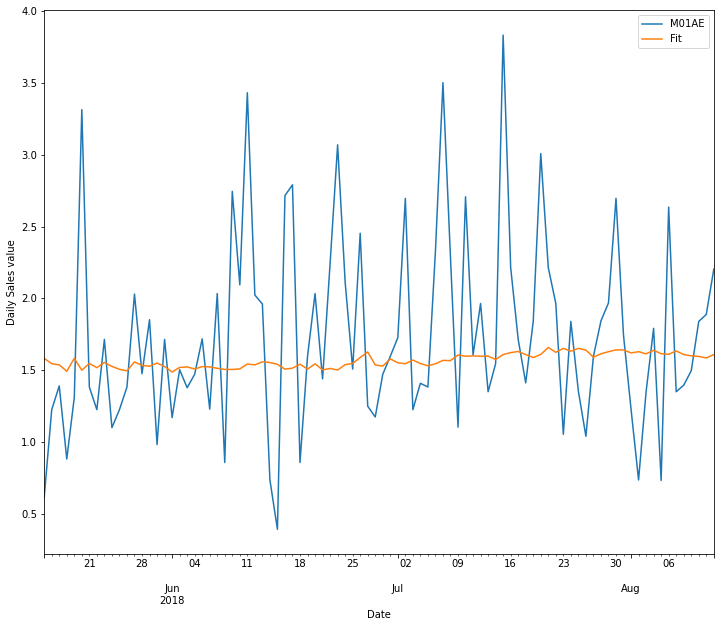

In [43]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_m01ae_train-1)[-90:].plot(figsize=(12, 10))
is_prediction2[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

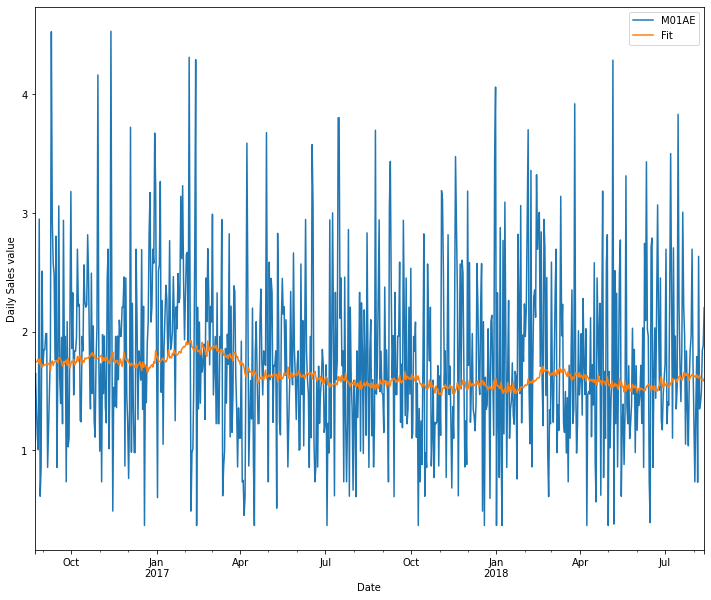

In [44]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_m01ae_train-1)[-720:].plot(figsize=(12, 10))
is_prediction2[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [45]:
# analyse in-sample residuals
is_residuals2 = is_prediction2['Fit'] - np.exp(log_m01ae_train-1)['M01AE']
arch_test2 = het_arch(is_residuals2, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test2[1]}')
print(f'F test p-value: {arch_test2[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals2, lags=[7], return_df=True))

# with these tests it can be seen that residuals have constant variance and are independent
# the fitted combined model is a good fit

Lagrange mulitplier p-value: 0.4543829321873034
F test p-value: 0.45695352778033294

Ljung-box test: 
   lb_stat  lb_pvalue
7  8.56848   0.285139


### N05B

In [46]:
n05b.head(5)

,N05B
date,
2014-01-02,7.0
2014-01-03,16.0
2014-01-04,10.0
2014-01-05,8.0
2014-01-06,16.0


In [47]:
# transformed series
np.log(n05b+1).head(5)

,N05B
date,
2014-01-02,2.079442
2014-01-03,2.833213
2014-01-04,2.397895
2014-01-05,2.197225
2014-01-06,2.833213


In [48]:
# train - test split
log_n05b = np.log(n05b+1)

index = int(len(log_n05b.index)*0.8)
log_n05b_train = log_n05b.iloc[:index,:]
log_n05b_test = log_n05b.iloc[index:,:]
print("Train: {} | Test: {}".format(log_n05b_train.shape, log_n05b_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [49]:
# fit best SARIMA model
log_n05b_fit = sm.tsa.statespace.SARIMAX(log_n05b_train,order=(7,1,1),seasonal_order=(2,0,0,24), enforce_stationarity=False, enforce_invertibility=False)
log_n05b_fit_sarima = log_n05b_fit.fit()

In [50]:
# output of best sarimax model
print(log_n05b_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_n05b_fit_sarima.resid, lags=[7], return_df=True))

                                      SARIMAX Results                                      
Dep. Variable:                                N05B   No. Observations:                 1684
Model:             SARIMAX(7, 1, 1)x(2, 0, [], 24)   Log Likelihood               -1508.773
Date:                             Sat, 19 Jun 2021   AIC                           3039.546
Time:                                     19:43:20   BIC                           3098.892
Sample:                                 01-02-2014   HQIC                          3061.564
                                      - 08-12-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1129      0.025      4.468      0.000       0.063       0.162
ar.L2          0.0294      

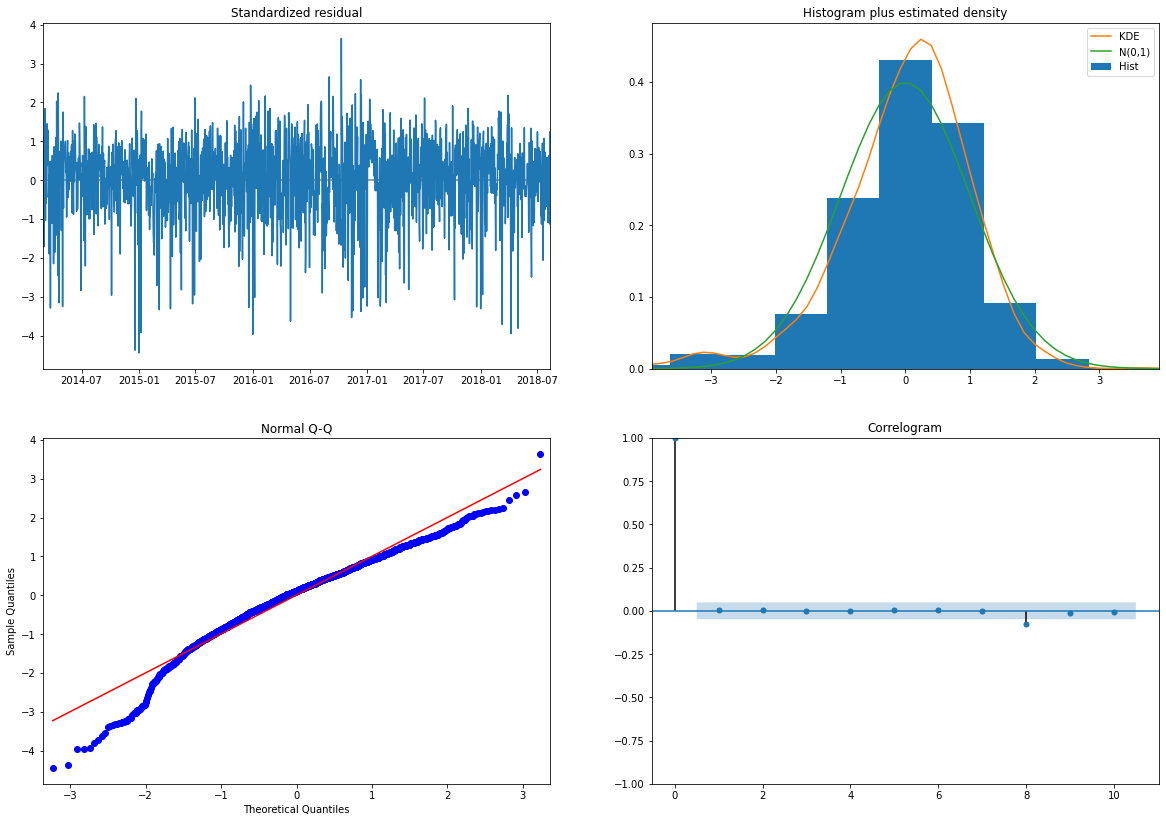

In [51]:
# visual check for residuals
log_n05b_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [52]:
sarima_residuals3 = log_n05b_fit_sarima.resid
sarima_residuals3.head(15)

date
2014-01-02    2.079442
2014-01-03    0.636357
2014-01-04   -0.552082
2014-01-05   -0.184768
2014-01-06    0.634123
2014-01-07   -2.854008
2014-01-08    3.275722
2014-01-09   -0.585544
2014-01-10   -0.154689
2014-01-11    0.075658
2014-01-12   -0.773690
2014-01-13    0.487960
2014-01-14   -0.360247
2014-01-15    0.455593
2014-01-16    0.396516
dtype: float64

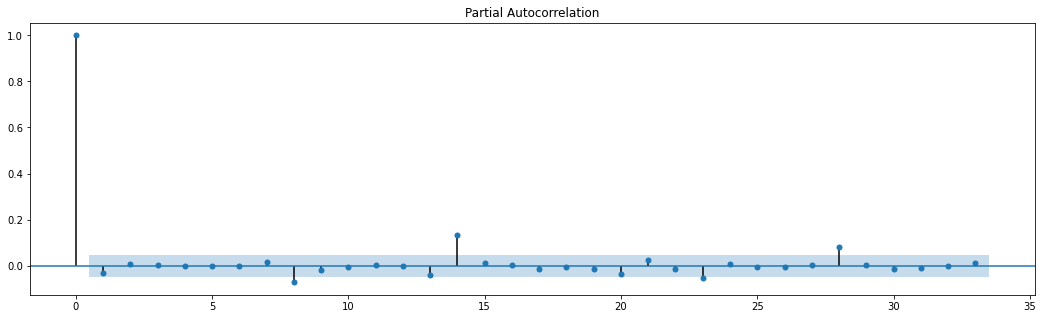

In [53]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals3)
plt.show()

In [54]:
# According to PACF analysis, a GARCH(14,1) better fits the remaining residues from the SARIMA model
# fit a GARCH(14,1) model on the residuals of the ARIMA model
garch_model3 = arch.arch_model(sarima_residuals3, p=14, q=1)
garch_fitted3 = garch_model3.fit()

Iteration:      1,   Func. Count:     19,   Neg. LLF: 5079.216157975525
Iteration:      2,   Func. Count:     40,   Neg. LLF: 2975801.8055088394
Iteration:      3,   Func. Count:     60,   Neg. LLF: 42471.62907029751
Iteration:      4,   Func. Count:     79,   Neg. LLF: 1980.9557367367622
Iteration:      5,   Func. Count:     99,   Neg. LLF: 2562.625566553471
Iteration:      6,   Func. Count:    119,   Neg. LLF: 1601.113022791779
Iteration:      7,   Func. Count:    138,   Neg. LLF: 1767.2138127799044
Iteration:      8,   Func. Count:    158,   Neg. LLF: 2638.2684954523356
Iteration:      9,   Func. Count:    178,   Neg. LLF: 1897.5635318419131
Iteration:     10,   Func. Count:    198,   Neg. LLF: 1744.842409725573
Iteration:     11,   Func. Count:    218,   Neg. LLF: 1574.0727443255619
Iteration:     12,   Func. Count:    237,   Neg. LLF: 1551.979411984104
Iteration:     13,   Func. Count:    256,   Neg. LLF: 1561.4782402402511
Iteration:     14,   Func. Count:    275,   Neg. LLF: 167

In [55]:
# Use SARIMA to predict mu
predicted_mu3 = log_n05b_fit_sarima.get_forecast('2019-10-08')
predicted_mu3 = predicted_mu3.predicted_mean
predicted_mu3 = pd.DataFrame(list(predicted_mu3), index=log_n05b_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast3 = garch_fitted3.forecast(horizon=422)
predicted_et3 = garch_forecast3.mean.iloc[-1,:]
predicted_et3 = pd.DataFrame(list(predicted_et3), index=log_n05b_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction3 = predicted_mu3 + predicted_et3
prediction3 = np.exp(prediction3-1)

In [56]:
prediction3

,Prediction
date,
2018-08-13,3.525051
2018-08-14,3.281403
2018-08-15,3.825606
2018-08-16,3.081967
2018-08-17,3.536712
...,...
2019-10-04,3.356486
2019-10-05,3.356486
2019-10-06,3.356486


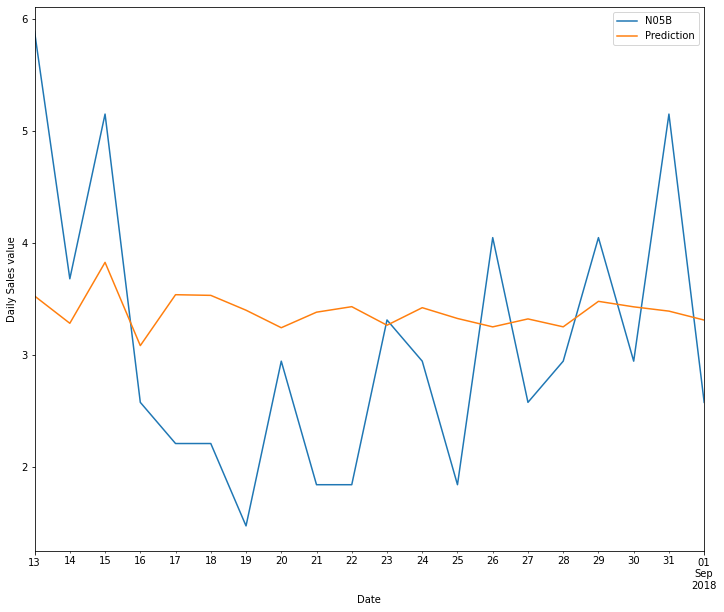

In [57]:
# plot predictions in the same picture
ax = np.exp(log_n05b_test-1)[:20].plot(figsize=(12, 10))
prediction3[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [58]:
# Evaluate Model
results_garch3 = np.exp(log_n05b_test-1).merge(prediction3, on='date')
results_garch3.head(15)

,N05B,Prediction
date,,
2018-08-13,5.886071,3.525051
2018-08-14,3.678794,3.281403
2018-08-15,5.150312,3.825606
2018-08-16,2.575156,3.081967
2018-08-17,2.207277,3.536712
2018-08-18,2.207277,3.530815
2018-08-19,1.471518,3.398209
2018-08-20,2.943036,3.241796
2018-08-21,1.839397,3.380628


In [59]:
RMSE_garch3 = mean_squared_error(results_garch3['N05B'], results_garch3['Prediction'], squared=False)
MAE_garch3 = mean_absolute_error(results_garch3['N05B'], results_garch3['Prediction'])

results_garch_non_null3 = results_garch3[results_garch3['N05B'] != 0]
MAPE_garch3 = np.abs(np.mean((results_garch_non_null3['Prediction'] - results_garch_non_null3['N05B']) / results_garch_non_null3['N05B'])) # MAPE for non-null values

print('GARCH - N05B')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch3, MAE_garch3, MAPE_garch3))

GARCH - N05B
RMSE: 1.5484043487759922 
MAE: 1.2335120639231087 
MAPE: 0.30425873443392776


In [60]:
# in-sample prediction
# SARIMAX
is_predicted_mu3 = log_n05b_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu3 = is_predicted_mu3.predicted_mean
is_predicted_mu3 = pd.DataFrame(list(is_predicted_mu3), index=log_n05b_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast3 = garch_fitted3.forecast(horizon=len(log_n05b_train.index), start='2014-01-02')
is_predicted_et3 = is_garch_forecast3.mean.iloc[0,:]
is_predicted_et3 = pd.DataFrame(list(is_predicted_et3), index=log_n05b_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction3 = is_predicted_mu3 + is_predicted_et3
is_prediction3 = np.exp(is_prediction3-1)

In [61]:
is_prediction3

,Fit
date,
2014-01-02,0.370058
2014-01-03,3.329294
2014-01-04,7.070142
2014-01-05,4.006411
2014-01-06,3.336738
...,...
2018-08-08,3.505216
2018-08-09,3.525191
2018-08-10,3.679016


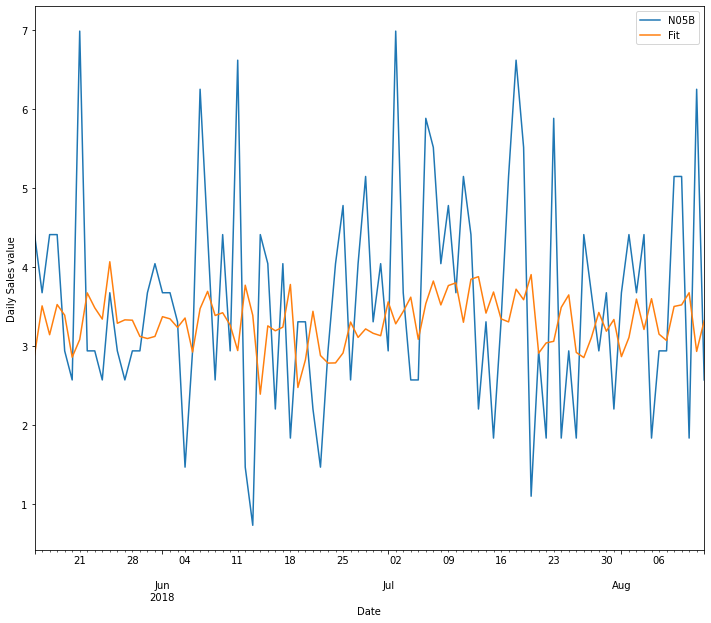

In [62]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_n05b_train-1)[-90:].plot(figsize=(12, 10))
is_prediction3[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

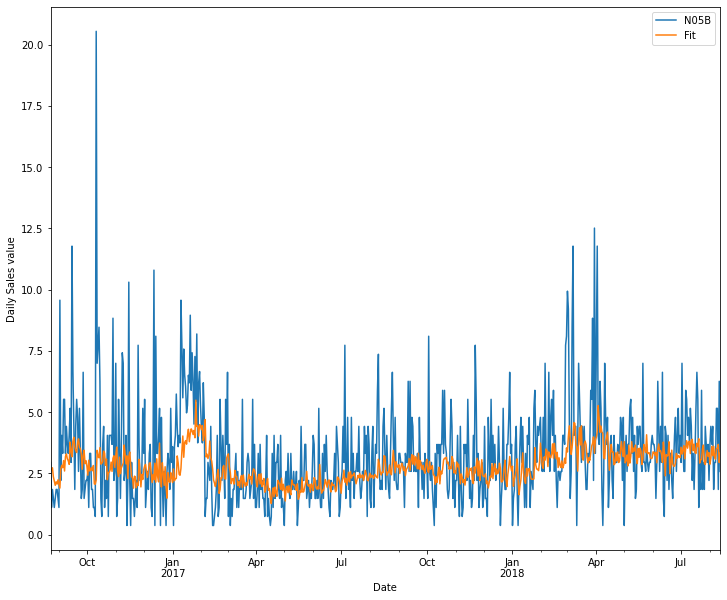

In [63]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_n05b_train-1)[-720:].plot(figsize=(12, 10))
is_prediction3[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [64]:
# analyse in-sample residuals
is_residuals3 = is_prediction3['Fit'] - np.exp(log_n05b_train-1)['N05B']
arch_test3 = het_arch(is_residuals3, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test3[1]}')
print(f'F test p-value: {arch_test3[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals3, lags=[14], return_df=True))

Lagrange mulitplier p-value: 2.022303256077598e-06
F test p-value: 8.381834130356373e-07

Ljung-box test: 
      lb_stat  lb_pvalue
14  48.528861   0.000011


In [65]:
# through the used tests, residuals from this model don't have constant variance and arent's independent 
# further modelling would be needed to achieve those results

### N05C

In [66]:
n05c.head(5)

,N05C
date,
2014-01-02,0.0
2014-01-03,0.0
2014-01-04,0.0
2014-01-05,0.0
2014-01-06,2.0


In [67]:
# transformed time-series
np.log(n05c+1).head(5)

,N05C
date,
2014-01-02,0.000000
2014-01-03,0.000000
2014-01-04,0.000000
2014-01-05,0.000000
2014-01-06,1.098612


In [68]:
# train - test split
log_n05c = np.log(n05c+1)

index = int(len(log_n05c.index)*0.8)
log_n05c_train = log_n05c.iloc[:index,:]
log_n05c_test = log_n05c.iloc[index:,:]
print("Train: {} | Test: {}".format(log_n05c_train.shape, log_n05c_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [69]:
# fit best SARIMA model
log_n05c_fit = sm.tsa.statespace.SARIMAX(log_n05c_train,order=(0,1,2),seasonal_order=(0,0,2,12), enforce_stationarity=False, enforce_invertibility=False)
log_n05c_fit_sarima = log_n05c_fit.fit()

In [70]:
# output of best sarimax model
print(log_n05c_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_n05c_fit_sarima.resid, lags=[2], return_df=True))

                                     SARIMAX Results                                      
Dep. Variable:                               N05C   No. Observations:                 1684
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 12)   Log Likelihood               -1163.264
Date:                            Sat, 19 Jun 2021   AIC                           2336.529
Time:                                    19:45:25   BIC                           2363.590
Sample:                                01-02-2014   HQIC                          2346.560
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9694      0.023    -41.391      0.000      -1.015      -0.923
ma.L2         -0.0131      0.023   

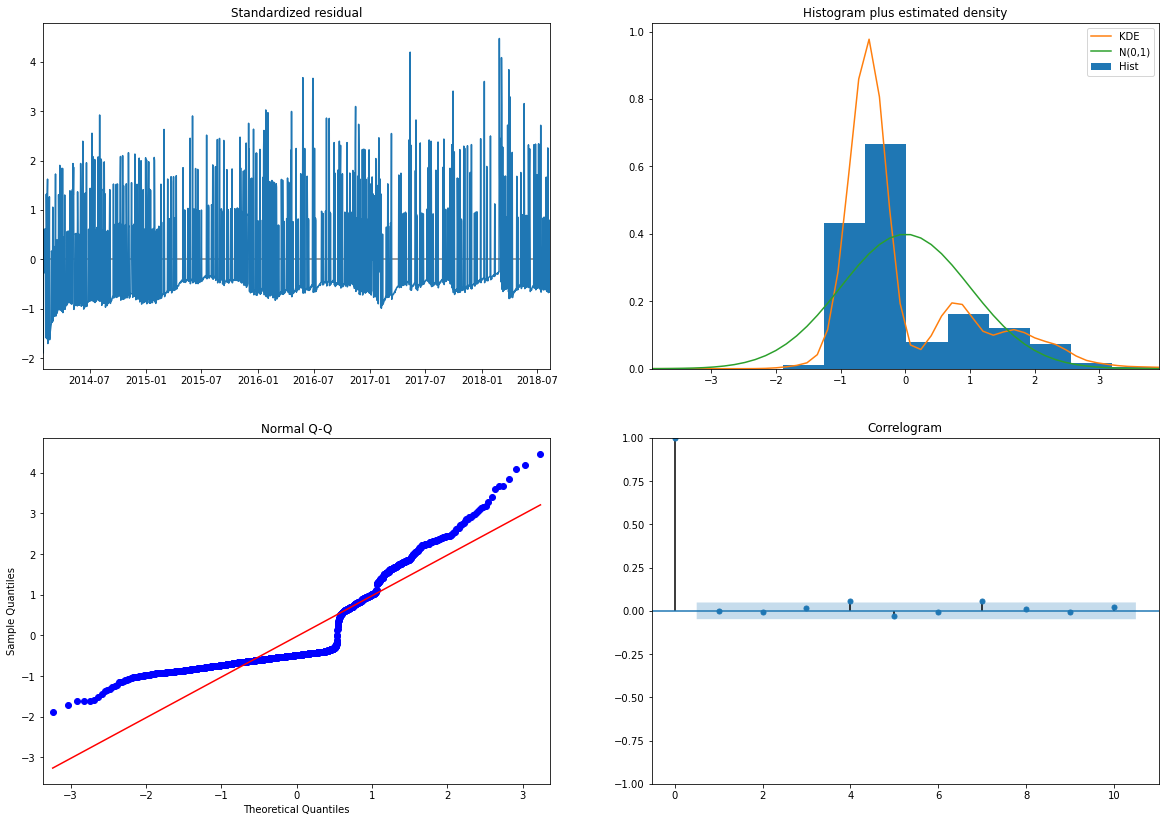

In [71]:
# visual check for residuals
log_n05c_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [72]:
sarima_residuals4 = log_n05c_fit_sarima.resid
sarima_residuals4.head(15)

date
2014-01-02    0.000000e+00
2014-01-03    0.000000e+00
2014-01-04    0.000000e+00
2014-01-05    0.000000e+00
2014-01-06    1.098612e+00
2014-01-07   -1.098612e+00
2014-01-08    6.931469e-01
2014-01-09   -6.931470e-01
2014-01-10    1.098612e+00
2014-01-11   -1.098612e+00
2014-01-12   -2.469141e-07
2014-01-13   -3.435759e-09
2014-01-14    6.931472e-01
2014-01-15    4.054653e-01
2014-01-16   -4.054650e-01
dtype: float64

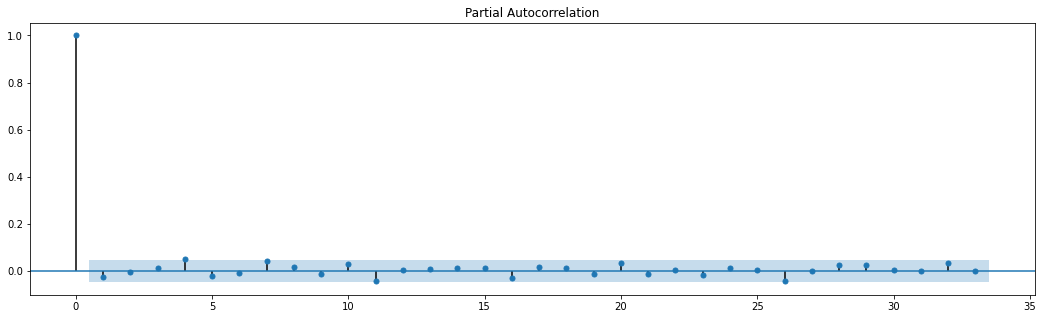

In [73]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals4)
plt.show()

In [74]:
# According to PACF analysis, residuals are similar to a white noise process, still let's use a GARCH(1,1) to try to improve predictions
# fit a GARCH(1,1) model on the residuals of the SARIMA model
garch_model4 = arch.arch_model(sarima_residuals4, p=1, q=1)
garch_fitted4 = garch_model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 538039751.1199602
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1206672964.2247887
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1587.0913814135256
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1525.2187172299614
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1222.994775600336
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1197.8480472058554
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1197.8473039068786
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1197.8472796284364
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1197.8472774210563
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1197.84727741908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1197.8472774210563
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


In [75]:
# Use SARIMA to predict mu
predicted_mu4 = log_n05c_fit_sarima.get_forecast('2019-10-08')
predicted_mu4 = predicted_mu4.predicted_mean
predicted_mu4 = pd.DataFrame(list(predicted_mu4), index=log_n05c_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast4 = garch_fitted4.forecast(horizon=422)
predicted_et4 = garch_forecast4.mean.iloc[-1,:]
predicted_et4 = pd.DataFrame(list(predicted_et4), index=log_n05c_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction4 = predicted_mu4 + predicted_et4
prediction4 = np.exp(prediction4-1)

In [76]:
prediction4

,Prediction
date,
2018-08-13,0.496934
2018-08-14,0.493539
2018-08-15,0.493554
2018-08-16,0.500810
2018-08-17,0.499923
...,...
2019-10-04,0.495983
2019-10-05,0.495983
2019-10-06,0.495983


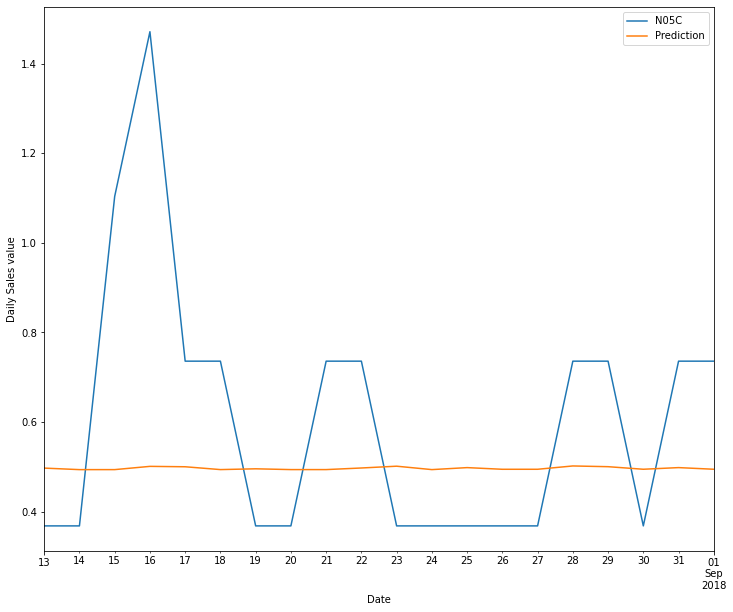

In [77]:
# plot predictions in the same picture
ax = np.exp(log_n05c_test-1)[:20].plot(figsize=(12, 10))
prediction4[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [78]:
# Evaluate Model
results_garch4 = np.exp(log_n05c_test-1).merge(prediction4, on='date')
results_garch4.head(15)

,N05C,Prediction
date,,
2018-08-13,0.367879,0.496934
2018-08-14,0.367879,0.493539
2018-08-15,1.103638,0.493554
2018-08-16,1.471518,0.500810
2018-08-17,0.735759,0.499923
2018-08-18,0.735759,0.493614
2018-08-19,0.367879,0.495370
2018-08-20,0.367879,0.493614
2018-08-21,0.735759,0.493614


In [79]:
RMSE_garch4 = mean_squared_error(results_garch4['N05C'], results_garch4['Prediction'], squared=False)
MAE_garch4 = mean_absolute_error(results_garch4['N05C'], results_garch4['Prediction'])

results_garch_non_null4 = results_garch4[results_garch4['N05C'] != 0]
MAPE_garch4 = np.abs(np.mean((results_garch_non_null4['Prediction'] - results_garch_non_null4['N05C']) / results_garch_non_null4['N05C'])) # MAPE for non-null values

print('GARCH - N05C')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch4, MAE_garch4, MAPE_garch4))

GARCH - N05C
RMSE: 0.42541369179464067 
MAE: 0.2859955243886172 
MAPE: 0.03658391772981618


In [80]:
# in-sample prediction
# SARIMAX
is_predicted_mu4 = log_n05c_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu4 = is_predicted_mu4.predicted_mean
is_predicted_mu4 = pd.DataFrame(list(is_predicted_mu4), index=log_n05c_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast4 = garch_fitted4.forecast(horizon=len(log_n05c_train.index), start='2014-01-02')
is_predicted_et4 = is_garch_forecast4.mean.iloc[0,:]
is_predicted_et4 = pd.DataFrame(list(is_predicted_et4), index=log_n05c_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction4 = is_predicted_mu4 + is_predicted_et4
is_prediction4 = np.exp(is_prediction4-1)

In [81]:
is_prediction4

,Fit
date,
2014-01-02,0.364449
2014-01-03,0.364449
2014-01-04,0.364449
2014-01-05,0.364449
2014-01-06,0.364449
...,...
2018-08-08,0.503749
2018-08-09,0.496257
2018-08-10,0.495359


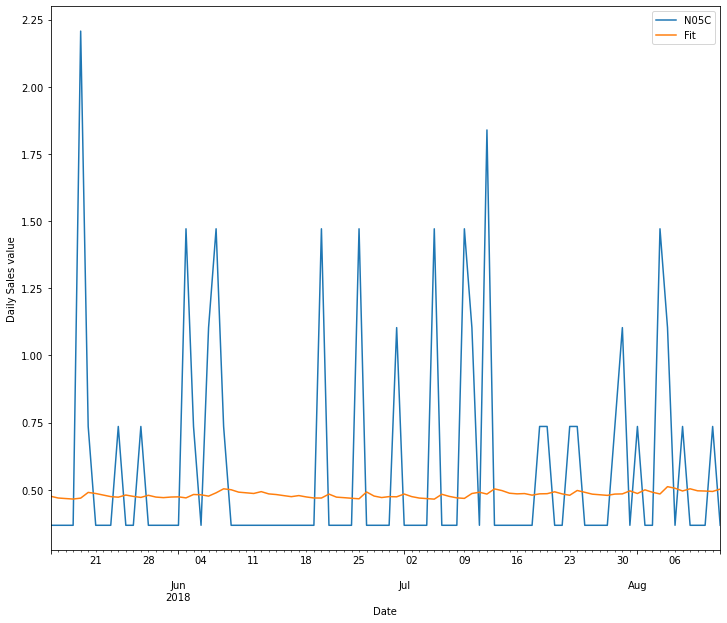

In [82]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_n05c_train-1)[-90:].plot(figsize=(12, 10))
is_prediction4[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

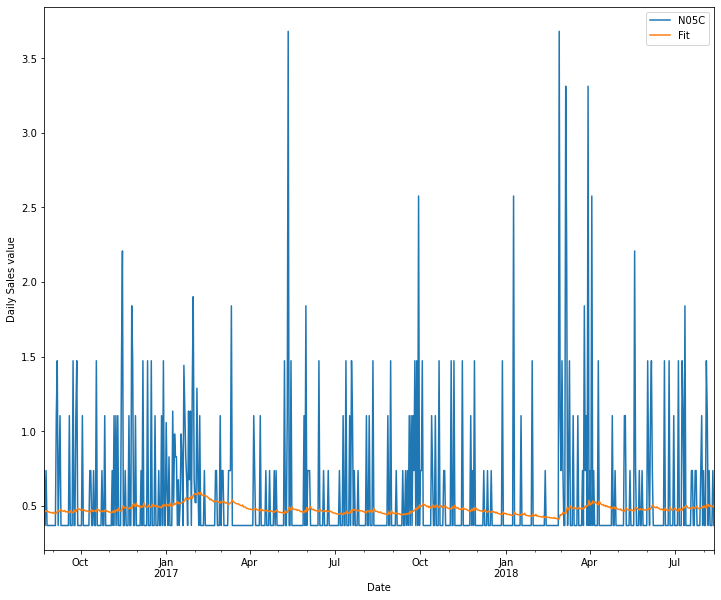

In [83]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_n05c_train-1)[-720:].plot(figsize=(12, 10))
is_prediction4[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [84]:
# analyse in-sample residuals
is_residuals4 = is_prediction4['Fit'] - np.exp(log_n05c_train-1)['N05C']
arch_test4 = het_arch(is_residuals4, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test4[1]}')
print(f'F test p-value: {arch_test4[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals4, lags=[2], return_df=True))

# residuals from this model are independen't but don't have constant variance
# further modelling is needed to improve these results

Lagrange mulitplier p-value: 0.0004373770196357996
F test p-value: 0.0002924892500223214

Ljung-box test: 
    lb_stat  lb_pvalue
2  0.223137    0.89443


### N02BA

In [85]:
n02ba.head(5)

,N02BA
date,
2014-01-02,3.4
2014-01-03,4.4
2014-01-04,6.5
2014-01-05,7.0
2014-01-06,4.5


In [86]:
# transformed time-series
np.log(n02ba+1).head(5)

,N02BA
date,
2014-01-02,1.481605
2014-01-03,1.686399
2014-01-04,2.014903
2014-01-05,2.079442
2014-01-06,1.704748


In [87]:
# train - test split
log_n02ba = np.log(n02ba+1)

index = int(len(log_n02ba.index)*0.8)
log_n02ba_train = log_n02ba.iloc[:index,:]
log_n02ba_test = log_n02ba.iloc[index:,:]
print("Train: {} | Test: {}".format(log_n02ba_train.shape, log_n02ba_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [88]:
# fit best SARIMA model
log_n02ba_fit = sm.tsa.statespace.SARIMAX(log_n02ba_train,order=(5,1,7),seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_n02ba_fit_sarima = log_n02ba_fit.fit()

In [89]:
# output of best sarimax model
print(log_n02ba_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_n02ba_fit_sarima.resid, lags=[1], return_df=True))

                                      SARIMAX Results                                       
Dep. Variable:                                N02BA   No. Observations:                 1684
Model:             SARIMAX(5, 1, 7)x(0, 0, [1], 12)   Log Likelihood               -1247.994
Date:                              Sat, 19 Jun 2021   AIC                           2523.988
Time:                                      19:46:35   BIC                           2599.818
Sample:                                  01-02-2014   HQIC                          2552.092
                                       - 08-12-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8925      0.210     -4.247      0.000      -1.304      -0.481
ar.L2         -1.34

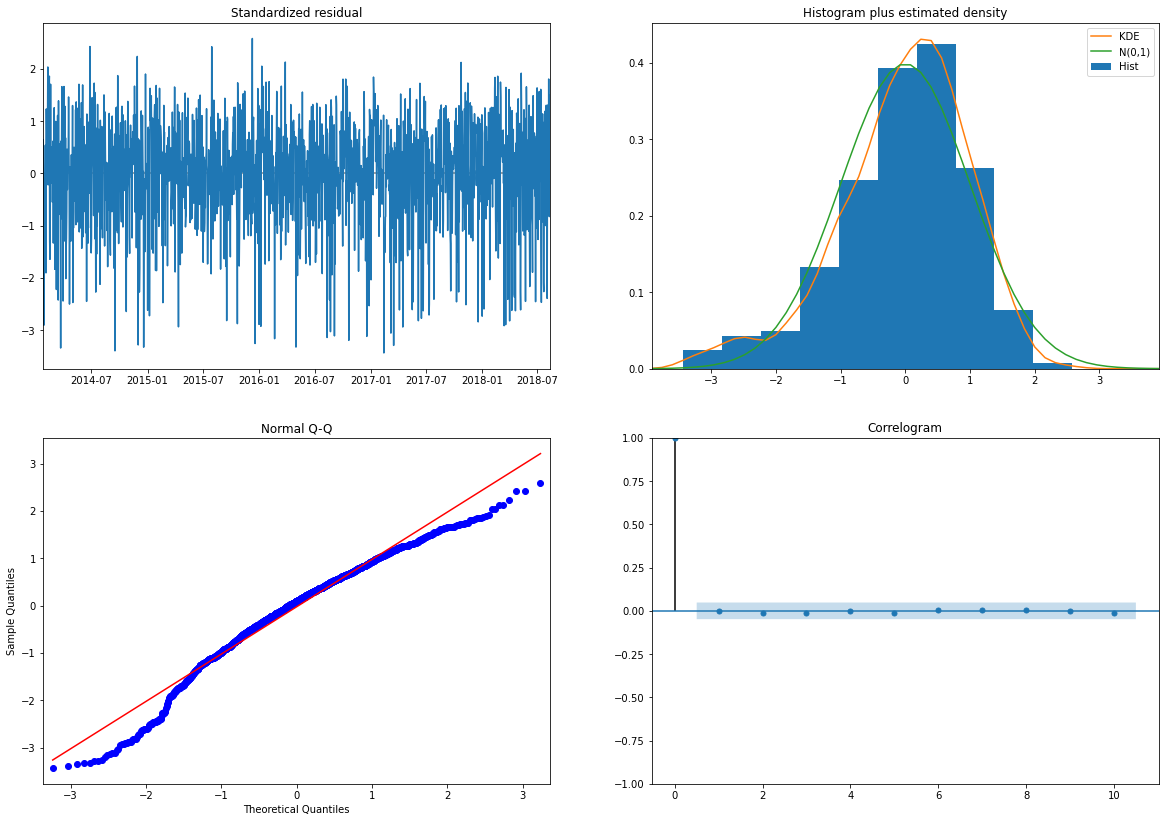

In [90]:
# visual check for residuals
log_n02ba_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [91]:
sarima_residuals5 = log_n02ba_fit_sarima.resid
sarima_residuals5.head(15)

date
2014-01-02    1.481605
2014-01-03    0.865944
2014-01-04    1.135346
2014-01-05    0.789031
2014-01-06    0.355116
2014-01-07   -1.507403
2014-01-08    0.772904
2014-01-09   -0.551509
2014-01-10   -0.160565
2014-01-11    1.894478
2014-01-12   -1.796631
2014-01-13    1.669189
2014-01-14    0.592414
2014-01-15   -0.799131
2014-01-16    1.194024
dtype: float64

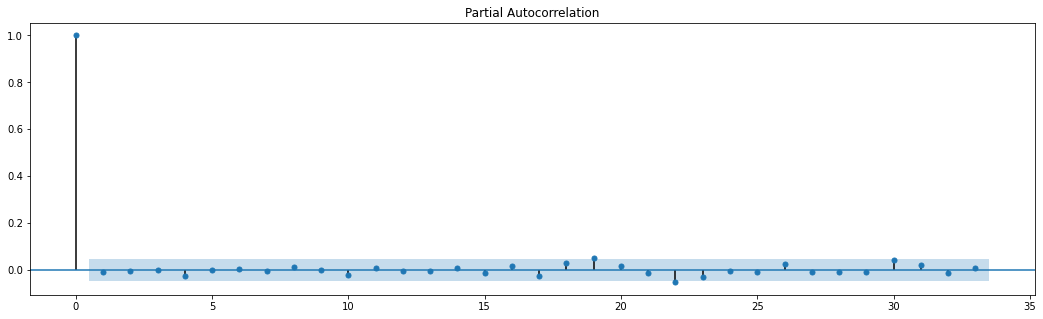

In [92]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals5)
plt.show()

In [93]:
# According to PACF analysis, residuals are similar to a white noise process, still let's use a GARCH(1,1)
# fit a GARCH(1,1) model on the residuals of the SARIMA model
garch_model5 = arch.arch_model(sarima_residuals5, p=1, q=1)
garch_fitted5 = garch_model5.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 815995759894.2876
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3084123688.0549545
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1663.6753730131086
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1276.4752933599289
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1277.5066222691164
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1297.707506486669
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1277.390110503718
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1275.5013730993178
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1275.4974425745752
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1275.4973304483788
Iteration:     11,   Func. Count:     69,   Neg. LLF: 1275.497328793239
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1275.4973287908751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1275.497328793239
            Iteratio

In [94]:
# Use SARIMA to predict mu
predicted_mu5 = log_n02ba_fit_sarima.get_forecast('2019-10-08')
predicted_mu5 = predicted_mu5.predicted_mean
predicted_mu5 = pd.DataFrame(list(predicted_mu5), index=log_n02ba_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast5 = garch_fitted5.forecast(horizon=422)
predicted_et5 = garch_forecast5.mean.iloc[-1,:]
predicted_et5 = pd.DataFrame(list(predicted_et5), index=log_n02ba_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction5 = predicted_mu5 + predicted_et5
prediction5 = np.exp(prediction5-1)

In [95]:
prediction5

,Prediction
date,
2018-08-13,1.293676
2018-08-14,1.382610
2018-08-15,1.138332
2018-08-16,1.249854
2018-08-17,1.271390
...,...
2019-10-04,1.284227
2019-10-05,1.272542
2019-10-06,1.250090


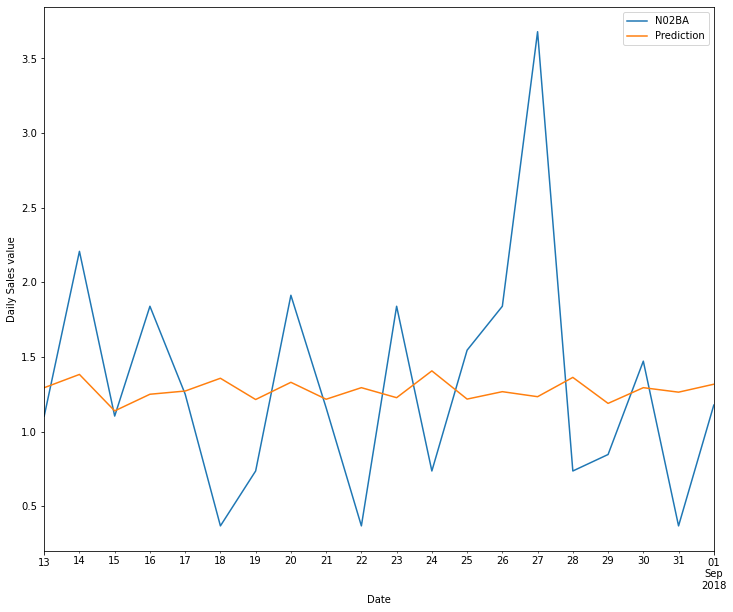

In [96]:
# plot predictions in the same picture
ax = np.exp(log_n02ba_test-1)[:20].plot(figsize=(12, 10))
prediction5[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [97]:
# Evaluate Model
results_garch5 = np.exp(log_n02ba_test-1).merge(prediction5, on='date')
results_garch5.head(15)

,N02BA,Prediction
date,,
2018-08-13,1.103638,1.293676
2018-08-14,2.207277,1.382610
2018-08-15,1.103638,1.138332
2018-08-16,1.839397,1.249854
2018-08-17,1.250790,1.271390
2018-08-18,0.367879,1.356963
2018-08-19,0.735759,1.214551
2018-08-20,1.912973,1.329826
2018-08-21,1.158820,1.216426


In [98]:
RMSE_garch5 = mean_squared_error(results_garch5['N02BA'], results_garch5['Prediction'], squared=False)
MAE_garch5 = mean_absolute_error(results_garch5['N02BA'], results_garch5['Prediction'])

results_garch_non_null5 = results_garch5[results_garch5['N02BA'] != 0]
MAPE_garch5 = np.abs(np.mean((results_garch_non_null5['Prediction'] - results_garch_non_null5['N02BA']) / results_garch_non_null5['N02BA'])) # MAPE for non-null values

print('GARCH - N02BA')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch5, MAE_garch5, MAPE_garch5))

GARCH - N02BA
RMSE: 0.7488387461609044 
MAE: 0.5626757599127274 
MAPE: 0.1344330467676553


In [99]:
# in-sample prediction
# SARIMAX
is_predicted_mu5 = log_n02ba_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu5 = is_predicted_mu5.predicted_mean
is_predicted_mu5 = pd.DataFrame(list(is_predicted_mu5), index=log_n02ba_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast5 = garch_fitted5.forecast(horizon=len(log_n02ba_train.index), start='2014-01-02')
is_predicted_et5 = is_garch_forecast5.mean.iloc[0,:]
is_predicted_et5 = pd.DataFrame(list(is_predicted_et5), index=log_n02ba_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction5 = is_predicted_mu5 + is_predicted_et5
is_prediction5 = np.exp(is_prediction5-1)

In [100]:
is_prediction5

,Fit
date,
2014-01-02,0.363196
2014-01-03,0.825011
2014-01-04,0.875241
2014-01-05,1.319955
2014-01-06,1.400486
...,...
2018-08-08,1.276786
2018-08-09,1.107770
2018-08-10,1.318292


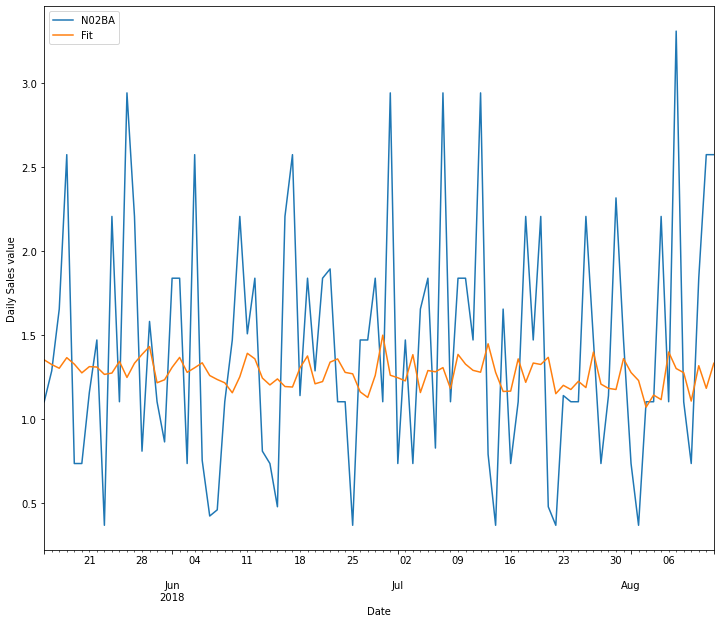

In [101]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_n02ba_train-1)[-90:].plot(figsize=(12, 10))
is_prediction5[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

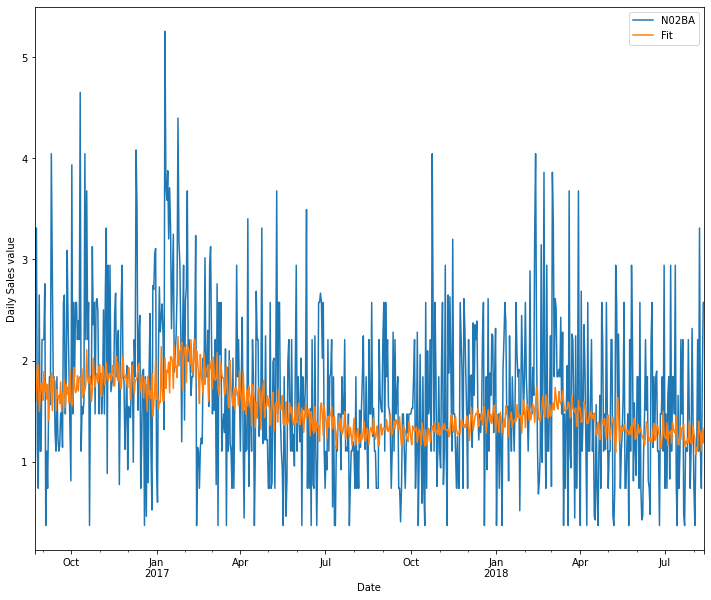

In [102]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_n02ba_train-1)[-720:].plot(figsize=(12, 10))
is_prediction5[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [103]:
# analyse in-sample residuals
is_residuals5 = is_prediction5['Fit'] - np.exp(log_n02ba_train-1)['N02BA']
arch_test5 = het_arch(is_residuals5, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test5[1]}')
print(f'F test p-value: {arch_test5[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals5, lags=[2], return_df=True))

# residuals from this model are independent but don't have constant variance
# further modelling is needed to improve these results

Lagrange mulitplier p-value: 0.00734000768594929
F test p-value: 0.00602149209616174

Ljung-box test: 
    lb_stat  lb_pvalue
2  0.449647   0.798657


### N02BE

In [104]:
n02be.head(5)

,N02BE
date,
2014-01-02,32.40
2014-01-03,50.60
2014-01-04,61.85
2014-01-05,41.10
2014-01-06,21.70


In [105]:
# transformed time-series
np.log(n02be+1).head(5)

,N02BE
date,
2014-01-02,3.508556
2014-01-03,3.943522
2014-01-04,4.140751
2014-01-05,3.740048
2014-01-06,3.122365


In [106]:
# train - test split
log_n02be = np.log(n02be+1)

index = int(len(log_n02be.index)*0.8)
log_n02be_train = log_n02be.iloc[:index,:]
log_n02be_test = log_n02be.iloc[index:,:]
print("Train: {} | Test: {}".format(log_n02be_train.shape, log_n02be_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [107]:
# fir best SARIMA model
log_n02be_fit = sm.tsa.statespace.SARIMAX(log_n02be_train,order=(7,0,7),seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_n02be_fit_sarima = log_n02be_fit.fit()

In [108]:
# output of best sarimax model
print(log_n02be_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_n02be_fit_sarima.resid, lags=[1], return_df=True))

                                      SARIMAX Results                                       
Dep. Variable:                                N02BE   No. Observations:                 1684
Model:             SARIMAX(7, 0, 7)x(0, 0, [1], 12)   Log Likelihood               -1285.329
Date:                              Sat, 19 Jun 2021   AIC                           2602.658
Time:                                      19:47:33   BIC                           2689.330
Sample:                                  01-02-2014   HQIC                          2634.779
                                       - 08-12-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2695      0.121      2.223      0.026       0.032       0.507
ar.L2         -0.07

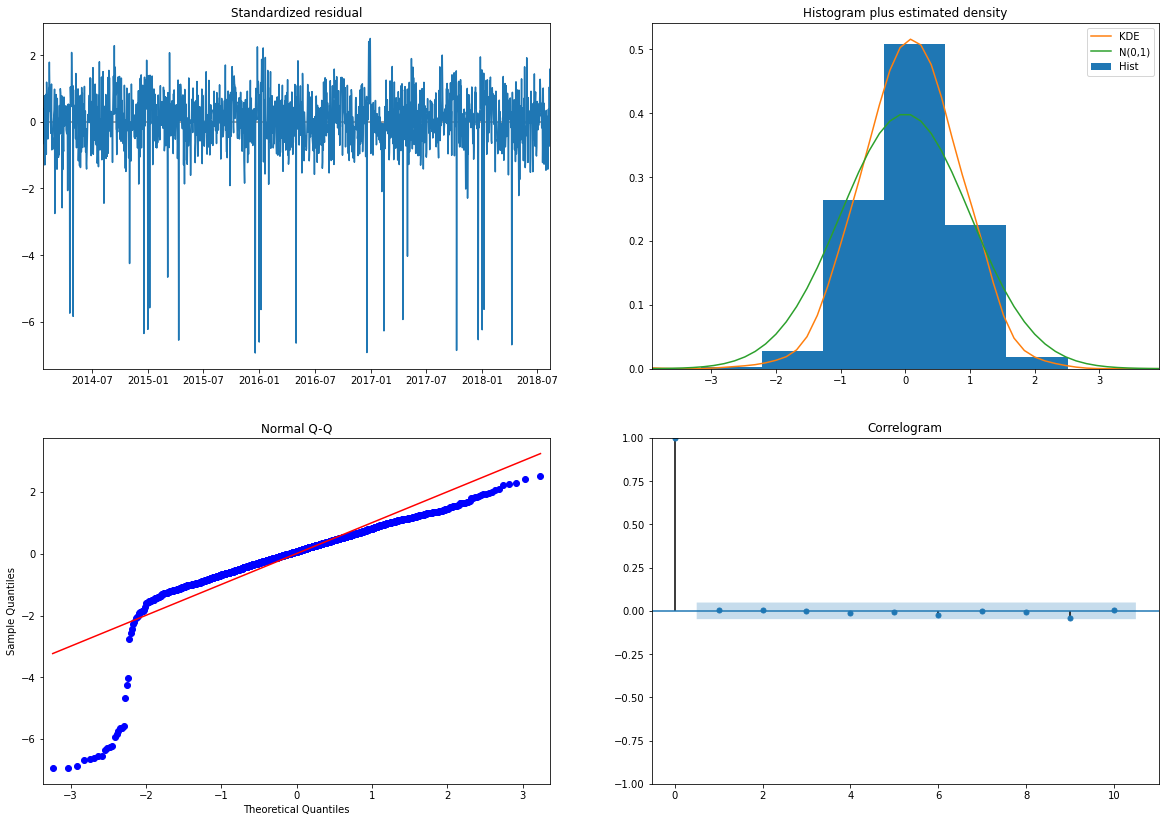

In [109]:
# visual check for residuals
log_n02be_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [110]:
sarima_residuals6 = log_n02be_fit_sarima.resid
sarima_residuals6.head(15)

date
2014-01-02    3.508556
2014-01-03    2.997913
2014-01-04    3.330711
2014-01-05    2.657207
2014-01-06    2.427231
2014-01-07   -1.117495
2014-01-08    2.978762
2014-01-09   -0.503080
2014-01-10    0.440464
2014-01-11   -0.309198
2014-01-12   -0.601010
2014-01-13    0.965996
2014-01-14    2.188447
2014-01-15   -0.006945
2014-01-16   -0.099787
dtype: float64

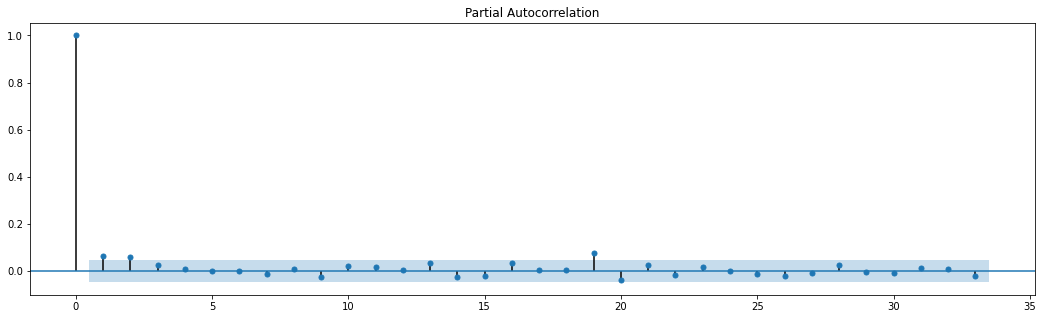

In [111]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals6)
plt.show()

In [112]:
# According to PACF analysis, residuals appear to have some partial autocorrelation in the 2nd lag
# fit a GARCH(2,1) model on the residuals of the SARIMA model
garch_model6 = arch.arch_model(sarima_residuals6, p=2, q=1)
garch_fitted6 = garch_model6.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 15068775323.370667
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1341565288.5316586
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1403.9155760654694
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3059.2305585508407
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1330.2837482731638
Iteration:      6,   Func. Count:     48,   Neg. LLF: 2753.7787767424606
Iteration:      7,   Func. Count:     56,   Neg. LLF: 1320.6792332717205
Iteration:      8,   Func. Count:     63,   Neg. LLF: 1309.7423993710217
Iteration:      9,   Func. Count:     69,   Neg. LLF: 1309.719880456221
Iteration:     10,   Func. Count:     75,   Neg. LLF: 1309.707049663122
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1309.6676887838462
Iteration:     12,   Func. Count:     87,   Neg. LLF: 1309.6650409472147
Iteration:     13,   Func. Count:     93,   Neg. LLF: 4624.828803487345
Iteration:     14,   Func. Count:    105,   Neg. LLF: 

In [113]:
# Use SARIMA to predict mu
predicted_mu6 = log_n02be_fit_sarima.get_forecast('2019-10-08')
predicted_mu6 = predicted_mu6.predicted_mean
predicted_mu6 = pd.DataFrame(list(predicted_mu6), index=log_n02be_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast6 = garch_fitted6.forecast(horizon=422)
predicted_et6 = garch_forecast6.mean.iloc[-1,:]
predicted_et6 = pd.DataFrame(list(predicted_et6), index=log_n02be_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction6 = predicted_mu6 + predicted_et6
prediction6 = np.exp(prediction6-1)

In [114]:
prediction6

,Prediction
date,
2018-08-13,7.072128
2018-08-14,6.476087
2018-08-15,6.921935
2018-08-16,7.062156
2018-08-17,7.587939
...,...
2019-10-04,5.848126
2019-10-05,5.845836
2019-10-06,5.843547


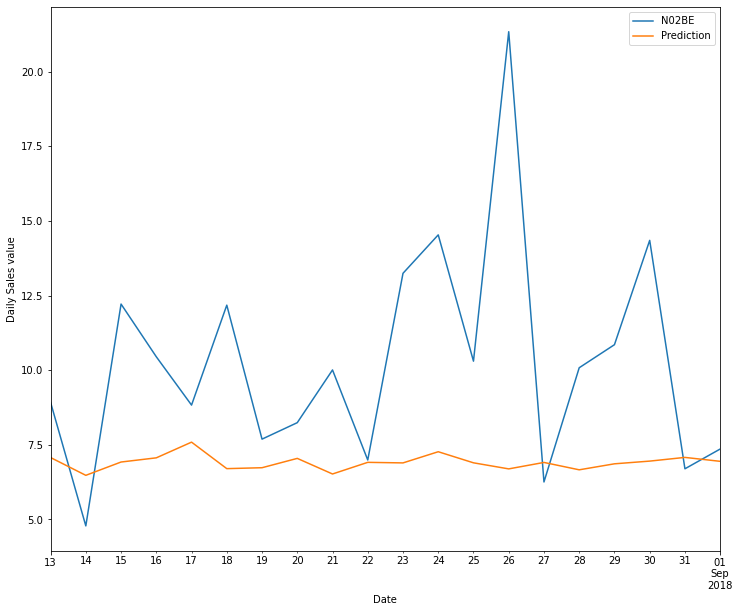

In [115]:
# plot predictions in the same picture
ax = np.exp(log_n02be_test-1)[:20].plot(figsize=(12, 10))
prediction6[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [116]:
# Evaluate Model
results_garch6 = np.exp(log_n02be_test-1).merge(prediction6, on='date')
results_garch6.head(15)

,N02BE,Prediction
date,,
2018-08-13,8.921076,7.072128
2018-08-14,4.782433,6.476087
2018-08-15,12.213597,6.921935
2018-08-16,10.447776,7.062156
2018-08-17,8.829107,7.587939
2018-08-18,12.176810,6.700342
2018-08-19,7.688680,6.731130
2018-08-20,8.240499,7.043631
2018-08-21,10.006321,6.521149


In [117]:
RMSE_garch6 = mean_squared_error(results_garch6['N02BE'], results_garch6['Prediction'], squared=False)
MAE_garch6 = mean_absolute_error(results_garch6['N02BE'], results_garch6['Prediction'])

results_garch_non_null6 = results_garch6[results_garch6['N02BE'] != 0]
MAPE_garch6 = np.abs(np.mean((results_garch_non_null6['Prediction'] - results_garch_non_null6['N02BE']) / results_garch_non_null6['N02BE'])) # MAPE for non-null values

print('GARCH - N02BE')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch6, MAE_garch6, MAPE_garch6))

GARCH - N02BE
RMSE: 7.762164499698965 
MAE: 5.74946545342978 
MAPE: 0.05252570871736867


In [118]:
# in-sample prediction
# SARIMAX
is_predicted_mu6 = log_n02be_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu6 = is_predicted_mu6.predicted_mean
is_predicted_mu6 = pd.DataFrame(list(is_predicted_mu6), index=log_n02be_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast6 = garch_fitted6.forecast(horizon=len(log_n02be_train.index), start='2014-01-02')
is_predicted_et6 = is_garch_forecast6.mean.iloc[0,:]
is_predicted_et6 = pd.DataFrame(list(is_predicted_et6), index=log_n02be_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction6 = is_predicted_mu6 + is_predicted_et6
is_prediction6 = np.exp(is_prediction6-1)

In [119]:
is_prediction6

,Fit
date,
2014-01-02,0.364007
2014-01-03,0.937092
2014-01-04,0.818286
2014-01-05,1.074932
2014-01-06,0.729462
...,...
2018-08-08,5.864884
2018-08-09,6.396376
2018-08-10,6.323262


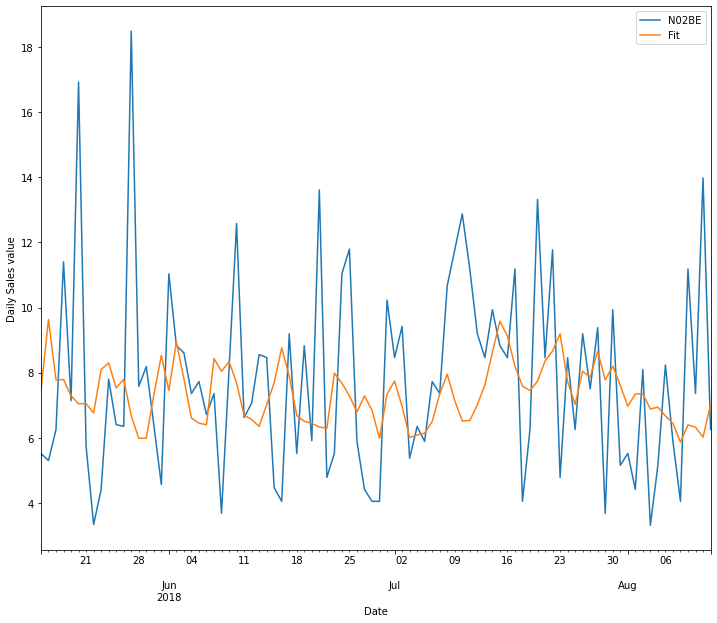

In [120]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_n02be_train-1)[-90:].plot(figsize=(12, 10))
is_prediction6[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

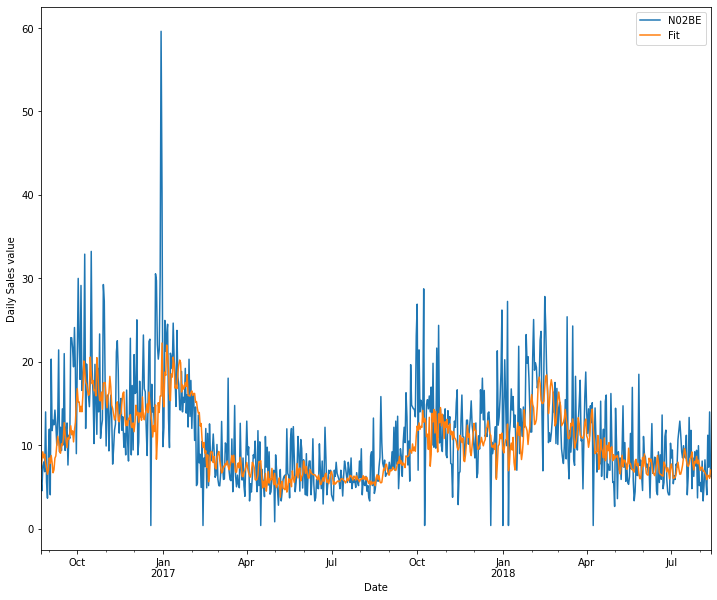

In [121]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_n02be_train-1)[-720:].plot(figsize=(12, 10))
is_prediction6[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [122]:
# analyse in-sample residuals
is_residuals6 = is_prediction6['Fit'] - np.exp(log_n02be_train-1)['N02BE']
arch_test6 = het_arch(is_residuals6, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test6[1]}')
print(f'F test p-value: {arch_test6[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals6, lags=[2], return_df=True))

# residuals from thie model aren't either independent or have constant variance
# further modelling must be done to improve these results

Lagrange mulitplier p-value: 8.470307365388058e-10
F test p-value: 1.4869895183305864e-10

Ljung-box test: 
     lb_stat     lb_pvalue
2  61.842676  3.724205e-14


### R03

In [123]:
r03.head(5)

,R03
date,
2014-01-02,0.0
2014-01-03,20.0
2014-01-04,9.0
2014-01-05,3.0
2014-01-06,6.0


In [124]:
# transformed time-series
np.log(r03+1)

,R03
date,
2014-01-02,0.000000
2014-01-03,3.044522
2014-01-04,2.302585
2014-01-05,1.386294
2014-01-06,1.945910
...,...
2019-10-04,0.693147
2019-10-05,0.000000
2019-10-06,1.791759


In [125]:
# train - test split
log_r03 = np.log(r03+1)

index = int(len(log_r03.index)*0.8)
log_r03_train = log_r03.iloc[:index,:]
log_r03_test = log_r03.iloc[index:,:]
print("Train: {} | Test: {}".format(log_r03_train.shape, log_r03_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [126]:
# fit best SARIMA model
log_r03_fit = sm.tsa.statespace.SARIMAX(log_r03_train,order=(0,1,1),seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_r03_fit_sarima = log_r03_fit.fit()

In [127]:
# output of best sarimax model
print(log_r03_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_r03_fit_sarima.resid, lags=[1], return_df=True))

                                     SARIMAX Results                                      
Dep. Variable:                                R03   No. Observations:                 1684
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2291.127
Date:                            Sat, 19 Jun 2021   AIC                           4588.254
Time:                                    19:48:32   BIC                           4604.492
Sample:                                01-02-2014   HQIC                          4594.273
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9451      0.008   -112.972      0.000      -0.961      -0.929
ma.S.L12      -1.0000     31.593   

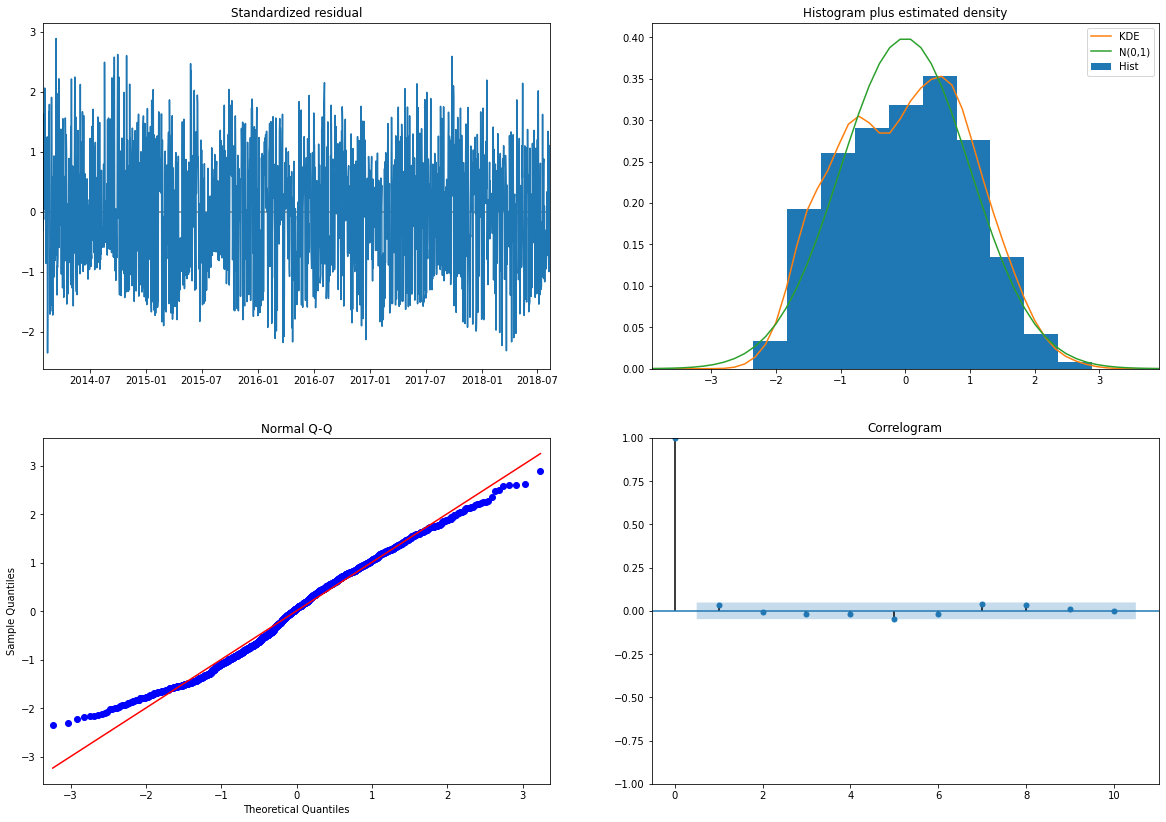

In [128]:
# visual check for residuals
log_r03_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [129]:
sarima_residuals7 = log_r03_fit_sarima.resid
sarima_residuals7.head(15)

date
2014-01-02    0.000000e+00
2014-01-03    3.044522e+00
2014-01-04   -7.419360e-01
2014-01-05   -9.162910e-01
2014-01-06    5.596154e-01
2014-01-07   -1.945910e+00
2014-01-08    2.397894e+00
2014-01-09   -1.011600e+00
2014-01-10   -1.386295e+00
2014-01-11    6.931466e-01
2014-01-12    2.951706e-07
2014-01-13    1.386294e+00
2014-01-14   -2.079441e+00
2014-01-15   -1.658227e+00
2014-01-16    1.147398e+00
dtype: float64

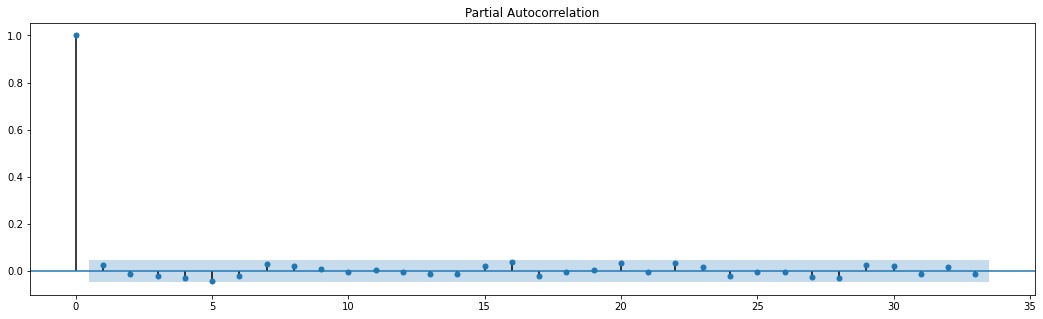

In [130]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals7)
plt.show()

In [131]:
# According to PACF analysis, residuals are similar to a white noise process, still let's use a GARCH(1,1)
# fit a GARCH(1,1) model on the residuals of the SARIMA model
garch_model7 = arch.arch_model(sarima_residuals7, p=1, q=1)
garch_fitted7 = garch_model7.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 56996336259.17136
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4171378934735.5215
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7300.867476114374
Iteration:      4,   Func. Count:     32,   Neg. LLF: 2399.248776792235
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2334.7701506815038
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2334.7695654641
Iteration:      7,   Func. Count:     50,   Neg. LLF: 2334.7695383698756
Iteration:      8,   Func. Count:     55,   Neg. LLF: 2334.769534270433
Iteration:      9,   Func. Count:     59,   Neg. LLF: 2334.7695342702855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2334.769534270433
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


In [132]:
# Use SARIMA to predict mu
predicted_mu7 = log_r03_fit_sarima.get_forecast('2019-10-08')
predicted_mu7 = predicted_mu7.predicted_mean
predicted_mu7 = pd.DataFrame(list(predicted_mu7), index=log_r03_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast7 = garch_fitted7.forecast(horizon=422)
predicted_et7 = garch_forecast7.mean.iloc[-1,:]
predicted_et7 = pd.DataFrame(list(predicted_et7), index=log_r03_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction7 = predicted_mu7 + predicted_et7
prediction7 = np.exp(prediction7-1)

In [133]:
prediction7

,Prediction
date,
2018-08-13,0.820292
2018-08-14,0.802492
2018-08-15,0.709051
2018-08-16,0.745300
2018-08-17,0.766399
...,...
2019-10-04,0.664130
2019-10-05,0.712596
2019-10-06,0.581820


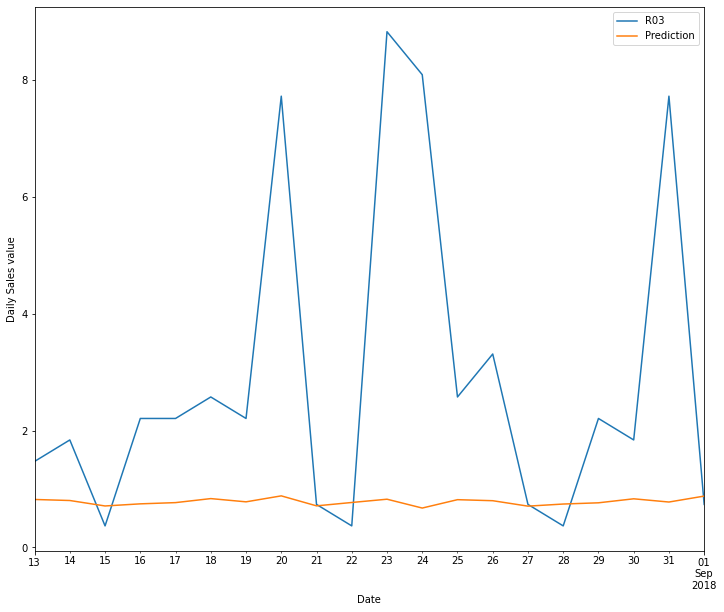

In [134]:
# plot predictions in the same picture
ax = np.exp(log_r03_test-1)[:20].plot(figsize=(12, 10))
prediction7[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [135]:
# Evaluate Model
results_garch7 = np.exp(log_r03_test-1).merge(prediction7, on='date')
results_garch7.head(15)

,R03,Prediction
date,,
2018-08-13,1.471518,0.820292
2018-08-14,1.839397,0.802492
2018-08-15,0.367879,0.709051
2018-08-16,2.207277,0.745300
2018-08-17,2.207277,0.766399
2018-08-18,2.575156,0.835251
2018-08-19,2.207277,0.779765
2018-08-20,7.725468,0.881981
2018-08-21,0.735759,0.710893


In [136]:
RMSE_garch7 = mean_squared_error(results_garch7['R03'], results_garch7['Prediction'], squared=False)
MAE_garch7 = mean_absolute_error(results_garch7['R03'], results_garch7['Prediction'])

results_garch_non_null7 = results_garch7[results_garch7['R03'] != 0]
MAPE_garch7 = np.abs(np.mean((results_garch_non_null7['Prediction'] - results_garch_non_null7['R03']) / results_garch_non_null7['R03'])) # MAPE for non-null values

print('GARCH - R03')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch7, MAE_garch7, MAPE_garch7))

GARCH - R03
RMSE: 3.904164266743647 
MAE: 2.608487706003221 
MAPE: 0.4153933970096217


In [137]:
# in-sample prediction
# SARIMAX
is_predicted_mu7 = log_r03_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu7 = is_predicted_mu7.predicted_mean
is_predicted_mu7 = pd.DataFrame(list(is_predicted_mu7), index=log_r03_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast7 = garch_fitted7.forecast(horizon=len(log_r03_train.index), start='2014-01-02')
is_predicted_et7 = is_garch_forecast7.mean.iloc[0,:]
is_predicted_et7 = pd.DataFrame(list(is_predicted_et7), index=log_r03_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction7 = is_predicted_mu7 + is_predicted_et7
is_prediction7 = np.exp(is_prediction7-1)

In [138]:
is_prediction7

,Fit
date,
2014-01-02,0.369104
2014-01-03,0.369104
2014-01-04,7.751180
2014-01-05,3.691044
2014-01-06,1.476418
...,...
2018-08-08,0.952050
2018-08-09,0.727310
2018-08-10,0.758005


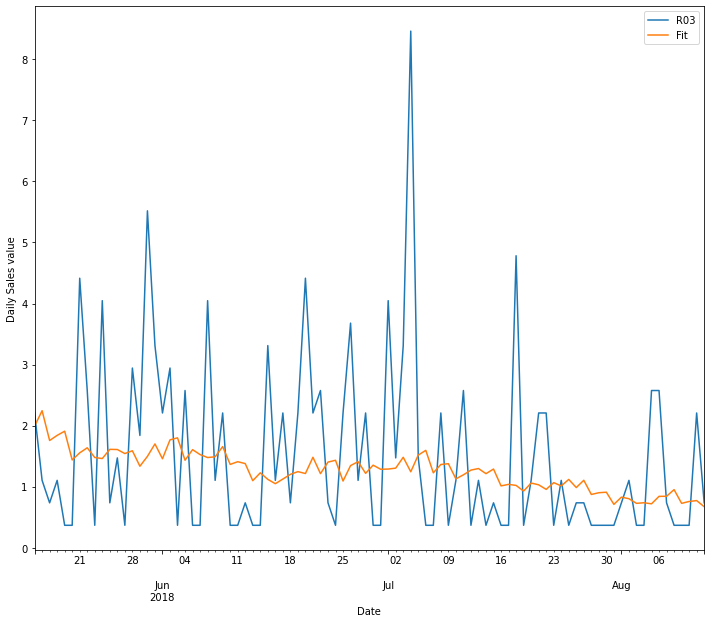

In [139]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_r03_train-1)[-90:].plot(figsize=(12, 10))
is_prediction7[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

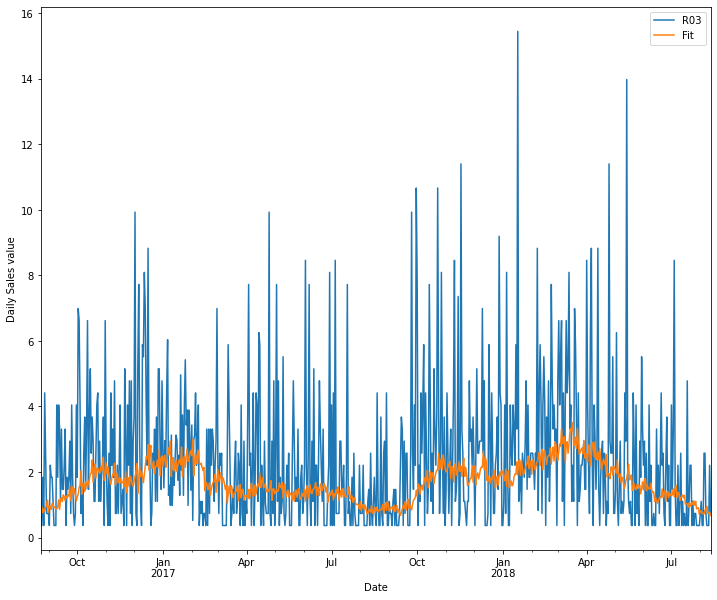

In [140]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_r03_train-1)[-720:].plot(figsize=(12, 10))
is_prediction7[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [141]:
# analyse in-sample residuals
is_residuals7 = is_prediction7['Fit'] - np.exp(log_r03_train-1)['R03']
arch_test7 = het_arch(is_residuals7, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test7[1]}')
print(f'F test p-value: {arch_test7[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals7, lags=[2], return_df=True))

# according to the residuals' tests, this fitted combined model is a good fit
# residuals have constant variance and are independent

Lagrange mulitplier p-value: 0.7617132755892649
F test p-value: 0.7696738253022918

Ljung-box test: 
    lb_stat  lb_pvalue
2  4.366651   0.112666


### R06

In [142]:
r06.head(5)

,R06
date,
2014-01-02,2.0
2014-01-03,4.0
2014-01-04,1.0
2014-01-05,0.0
2014-01-06,2.0


In [143]:
# transformed time-series
np.log(r06+1).head(5)

,R06
date,
2014-01-02,1.098612
2014-01-03,1.609438
2014-01-04,0.693147
2014-01-05,0.000000
2014-01-06,1.098612


In [144]:
# train - test split
log_r06 = np.log(r06+1)

index = int(len(log_r06.index)*0.8)
log_r06_train = log_r06.iloc[:index,:]
log_r06_test = log_r06.iloc[index:,:]
print("Train: {} | Test: {}".format(log_r06_train.shape, log_r06_test.shape))

Train: (1684, 1) | Test: (422, 1)


In [145]:
# fit best SARIMA model
log_r06_fit = sm.tsa.statespace.SARIMAX(log_r06_train,order=(0,1,1),seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
log_r06_fit_sarima = log_r06_fit.fit()

In [146]:
# output of best sarimax model
print(log_r06_fit_sarima.summary())
# validade previous Ljung-Box test
print(sm.stats.diagnostic.acorr_ljungbox(log_r06_fit_sarima.resid, lags=[1], return_df=True))

                                     SARIMAX Results                                      
Dep. Variable:                                R06   No. Observations:                 1684
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1367.279
Date:                            Sat, 19 Jun 2021   AIC                           2740.559
Time:                                    19:49:25   BIC                           2756.797
Sample:                                01-02-2014   HQIC                          2746.578
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9079      0.010    -88.203      0.000      -0.928      -0.888
ma.S.L12      -1.0000     32.740   

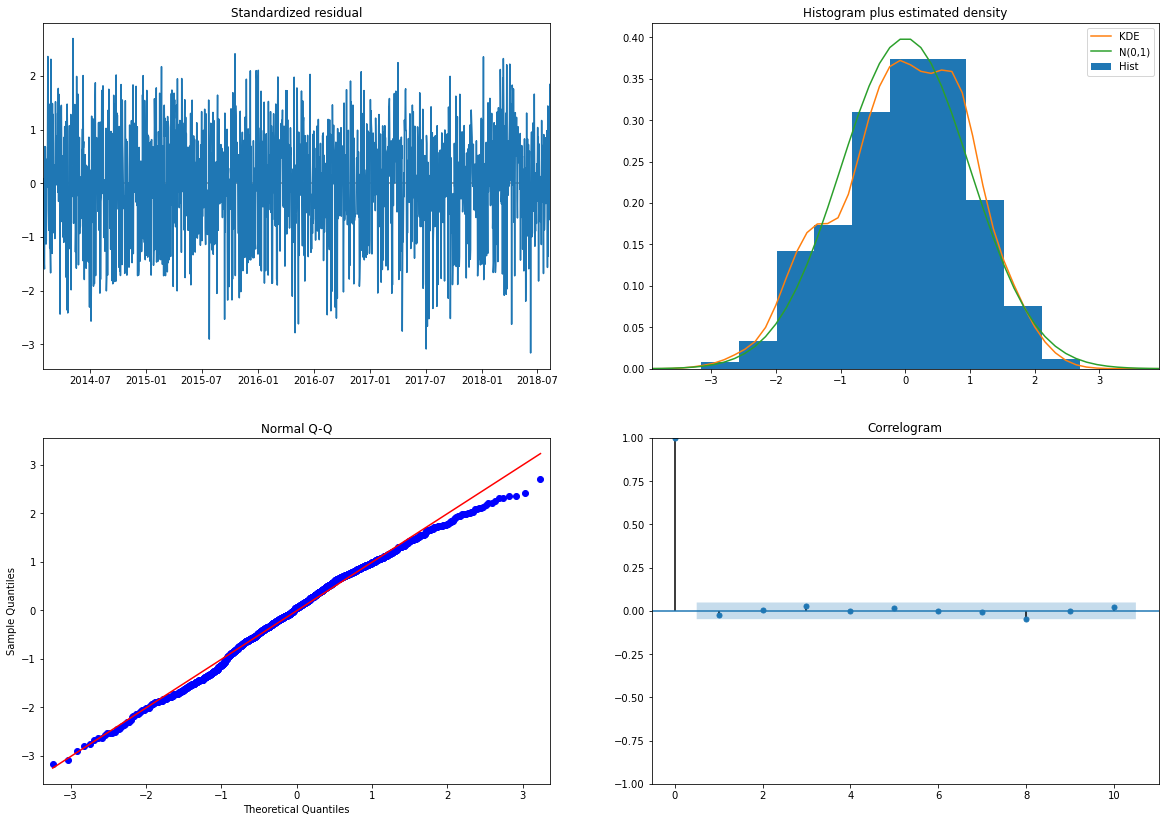

In [147]:
# visual check for residuals
log_r06_fit_sarima.plot_diagnostics(figsize=(20, 14))
plt.show()

In [148]:
sarima_residuals8 = log_r06_fit_sarima.resid
sarima_residuals8.head(15)

date
2014-01-02    1.098612e+00
2014-01-03    5.108256e-01
2014-01-04   -9.162907e-01
2014-01-05   -6.931473e-01
2014-01-06    1.098612e+00
2014-01-07   -1.098612e+00
2014-01-08   -1.474330e-07
2014-01-09    1.098612e+00
2014-01-10    1.474330e-07
2014-01-11   -9.162907e-01
2014-01-12    5.108255e-01
2014-01-13    6.855245e-08
2014-01-14   -3.269431e-01
2014-01-15   -2.231434e-01
2014-01-16   -4.700040e-01
dtype: float64

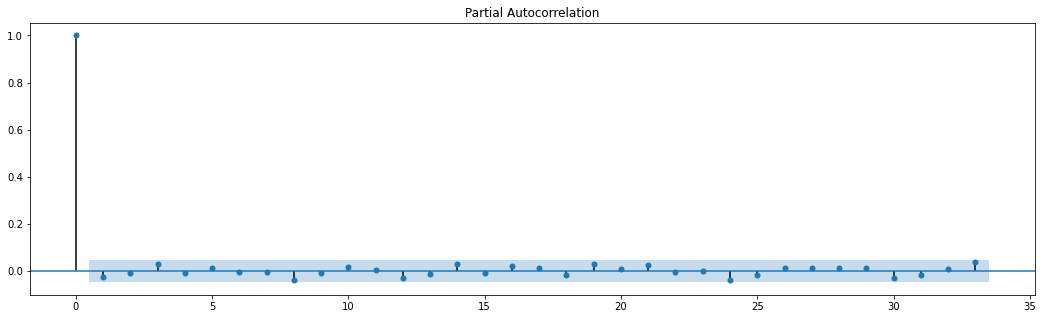

In [149]:
# GARCG(p,q): These parameters (p,q) are estimated by counting the number of significant lags in the PACF plot for the residuals.
plt.rcParams["figure.figsize"] = 18, 5
plot_pacf(sarima_residuals8)
plt.show()

In [150]:
# According to PACF analysis, residuals are similar to a white noise process, still let's use a GARCH(1,1)
# fit a GARCH(1,1) model on the residuals of the SARIMA model
garch_model8 = arch.arch_model(sarima_residuals8, p=1, q=1)
garch_fitted8 = garch_model8.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 487487760013.57996
Iteration:      2,   Func. Count:     15,   Neg. LLF: 28415882076.80442
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1750.8205648821813
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1477.4651079799758
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1443.5608501916213
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1435.0372779917752
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1434.8393187970808
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1440.8226599718605
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1411.641192811097
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1439.8601882093974
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1404.080304358476
Iteration:     12,   Func. Count:     78,   Neg. LLF: 1400.7434807333511
Iteration:     13,   Func. Count:     84,   Neg. LLF: 1400.3508343379337
Iteration:     14,   Func. Count:     89,   Neg. LLF: 

In [151]:
# Use SARIMA to predict mu
predicted_mu8 = log_r06_fit_sarima.get_forecast('2019-10-08')
predicted_mu8 = predicted_mu8.predicted_mean
predicted_mu8 = pd.DataFrame(list(predicted_mu8), index=log_r06_test.index, columns=['Prediction'])
# Use GARCH to predict the residual
garch_forecast8 = garch_fitted8.forecast(horizon=422)
predicted_et8 = garch_forecast8.mean.iloc[-1,:]
predicted_et8 = pd.DataFrame(list(predicted_et8), index=log_r06_test.index, columns=['Prediction'])
# Combine both models' output: yt = mu + et
prediction8 = predicted_mu8 + predicted_et8
prediction8 = np.exp(prediction8-1)

In [152]:
prediction8

,Prediction
date,
2018-08-13,1.594888
2018-08-14,1.596375
2018-08-15,1.483163
2018-08-16,1.414338
2018-08-17,1.534426
...,...
2019-10-04,1.923377
2019-10-05,1.867365
2019-10-06,1.801341


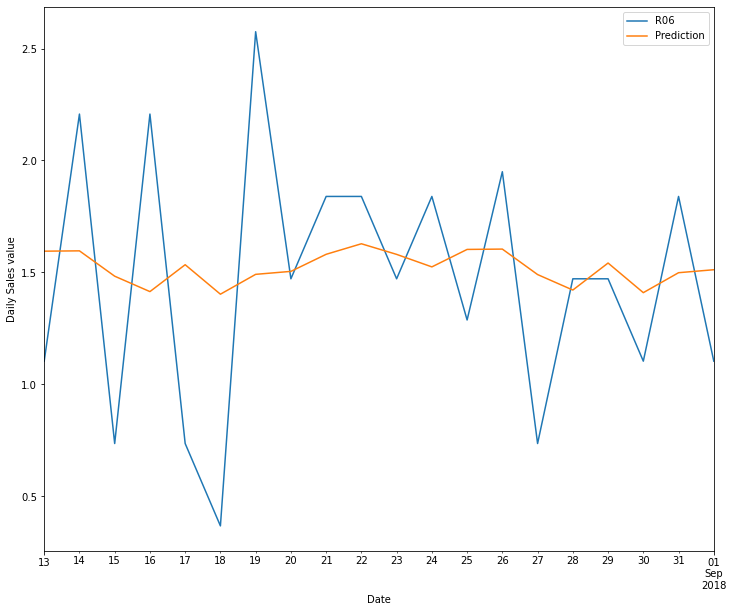

In [153]:
# plot predictions in the same picture
ax = np.exp(log_r06_test-1)[:20].plot(figsize=(12, 10))
prediction8[:20].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [154]:
# Evaluate Model
results_garch8 = np.exp(log_r06_test-1).merge(prediction8, on='date')
results_garch8.head(15)

,R06,Prediction
date,,
2018-08-13,1.103638,1.594888
2018-08-14,2.207277,1.596375
2018-08-15,0.735759,1.483163
2018-08-16,2.207277,1.414338
2018-08-17,0.735759,1.534426
2018-08-18,0.367879,1.402735
2018-08-19,2.575156,1.491409
2018-08-20,1.471518,1.504663
2018-08-21,1.839397,1.580905


In [155]:
RMSE_garch8 = mean_squared_error(results_garch8['R06'], results_garch8['Prediction'], squared=False)
MAE_garch8 = mean_absolute_error(results_garch8['R06'], results_garch8['Prediction'])

results_garch_non_null8 = results_garch8[results_garch8['R06'] != 0]
MAPE_garch8 = np.abs(np.mean((results_garch_non_null8['Prediction'] - results_garch_non_null8['R06']) / results_garch_non_null8['R06'])) # MAPE for non-null values

print('GARCH - R06')
print('RMSE: {} \nMAE: {} \nMAPE: {}'.format(RMSE_garch8, MAE_garch8, MAPE_garch8))

GARCH - R06
RMSE: 0.9174249332450779 
MAE: 0.7213748580104753 
MAPE: 0.5451693767191842


In [156]:
# in-sample prediction
# SARIMAX
is_predicted_mu8 = log_r06_fit_sarima.get_prediction(start='2014-01-02', dynamic=False)
is_predicted_mu8 = is_predicted_mu8.predicted_mean
is_predicted_mu8 = pd.DataFrame(list(is_predicted_mu8), index=log_r06_train.index, columns=['Fit'])
# Use GARCH to predict the residual
is_garch_forecast8 = garch_fitted8.forecast(horizon=len(log_r06_train.index), start='2014-01-02')
is_predicted_et8 = is_garch_forecast8.mean.iloc[0,:]
is_predicted_et8 = pd.DataFrame(list(is_predicted_et8), index=log_r06_train.index, columns=['Fit'])
# SARIMA + GARCH
is_prediction8 = is_predicted_mu8 + is_predicted_et8
is_prediction8 = np.exp(is_prediction8-1)

In [157]:
is_prediction8

,Fit
date,
2014-01-02,0.366105
2014-01-03,1.098315
2014-01-04,1.830525
2014-01-05,0.732210
2014-01-06,0.366105
...,...
2018-08-08,1.562698
2018-08-09,1.589966
2018-08-10,1.582784


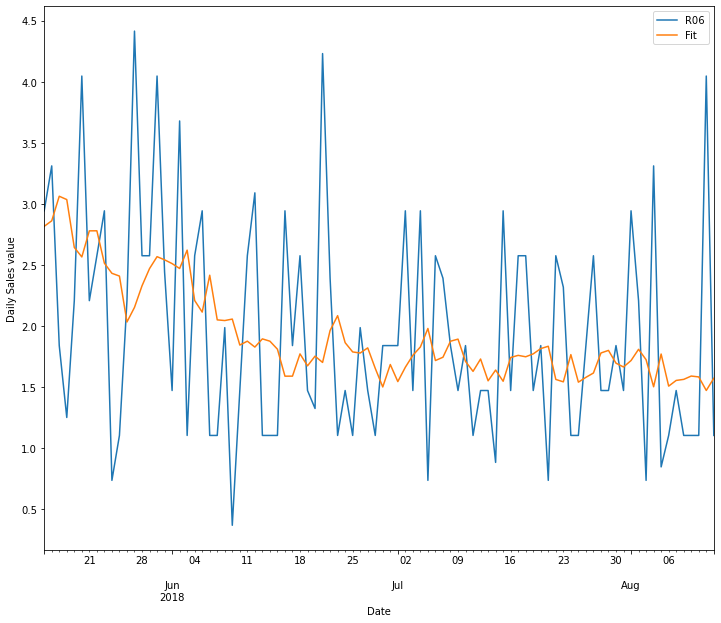

In [158]:
# plot short-term view of in sample predictions in the same picture
ax = np.exp(log_r06_train-1)[-90:].plot(figsize=(12, 10))
is_prediction8[-90:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

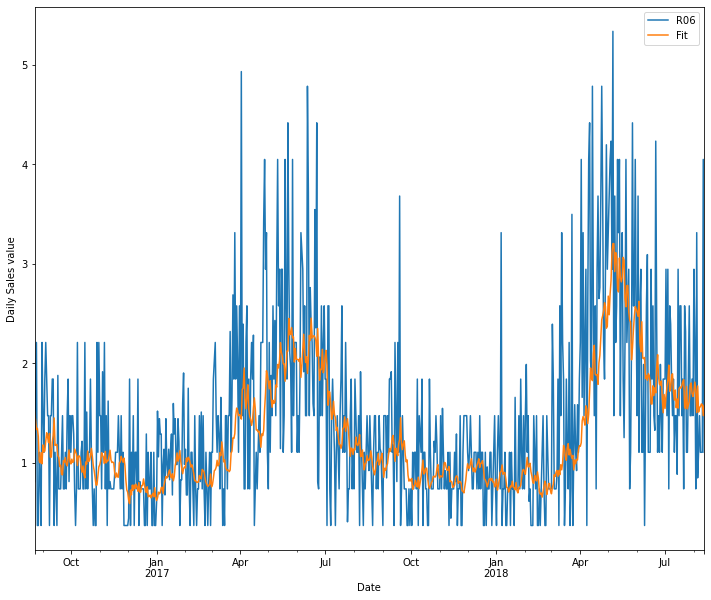

In [159]:
# plot medium-term view of in sample predictions in the same picture
ax = np.exp(log_r06_train-1)[-720:].plot(figsize=(12, 10))
is_prediction8[-720:].plot(ax=ax, label='SARIMAX + GARCH Forecast')
plt.ylabel('Daily Sales value')
plt.xlabel('Date')
plt.legend()

In [160]:
# analyse in-sample residuals
is_residuals8 = is_prediction8['Fit'] - np.exp(log_r06_train-1)['R06']
arch_test8 = het_arch(is_residuals8, maxlag=80)

print(f'Lagrange mulitplier p-value: {arch_test8[1]}')
print(f'F test p-value: {arch_test8[3]}')
print('\nLjung-box test: ')
print(sm.stats.diagnostic.acorr_ljungbox(is_residuals8, lags=[1], return_df=True))

# residuals from this model are independent but don't have constant variance
# further modellig is needed to get better results

Lagrange mulitplier p-value: 1.6053036186355183e-10
F test p-value: 2.291749900186093e-11

Ljung-box test: 
    lb_stat  lb_pvalue
1  0.041426   0.838719
